
## Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd '/content/drive/MyDrive/mental illness classification' && ls

## Installing Library

In [ ]:
!pip install -U -q openai
!pip install -U -q google-generativeai

## Loading the library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer,label_binarize
from sklearn.metrics import accuracy_score, f1_score, precision_score, precision_recall_curve,recall_score,roc_curve, auc,classification_report
from transformers import pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertTokenizer, DistilBertForSequenceClassification,XLNetTokenizer, XLNetForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification
import google.generativeai as genai
from google.colab import userdata
import torch
from tabulate import tabulate
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Loading the Data

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/mental.csv")
mental_df.head()

extended_tweet.full_text  \
0  @classpass Of course, I’ll do a couple more ra...   
1  @zjldlwn To TNX: \nI might have been attracted...   
2                                                NaN   
3  @Misses_Sniper77 @SavviiAnna I have to compart...   
4  Sorry but last night's anxiety dream was that ...   

   extended_tweet.entities.hashtags.text  
0                                    NaN  
1                                    NaN  
2                                    NaN  
3                                    NaN  
4                                    NaN

# Preprocessing

### Changing the column names

In [ ]:
mental_df.dropna(axis=0, subset=['extended_tweet.full_text'], inplace=True)
mental_df.columns = ['tweet','label']

### Drop rows where 'tweet' column is NaN


In [ ]:
mental_df.dropna(axis=0, subset=['tweet'], inplace=True)

In [ ]:
mental_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31623 entries, 0 to 68319
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tweet   31623 non-null  object 
 1   label   0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 741.2+ KB


 ## For preprocessing
* Convert the tweet to lowercase.
* Remove mentions, digits, and URLs.
* Replace non-letter characters with spaces.
* Tokenize the tweet into words.
* Remove short words (length < 3) and stopwords.
* Lemmatize the remaining words.
* Join the words back into a single string.

In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)
    words = nltk.word_tokenize(tweet)
    words = [word for word in words if len(word) > 3 and word not in stopwords.words('english')]
    words = [lemmatizer.lemmatize(word) for word in words]
    processed_tweet = ' '.join(words)
    return processed_tweet

mental_df['clean_tweet'] = mental_df['tweet'].apply(preprocess_tweet)

### Drop rows where 'clean_tweet' column is NaN

In [ ]:
mental_df.dropna(axis=0, subset=['clean_tweet'], inplace=True)
# Remove rows where 'clean_tweet' is an empty string
mental_df = mental_df[mental_df['clean_tweet'] != '']
mental_df.reset_index(drop=True, inplace=True)
print(mental_df['clean_tweet'].isna().sum())

0


In [ ]:
mental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31604 entries, 0 to 31603
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tweet        31604 non-null  object 
 1   label        0 non-null      float64
 2   clean_tweet  31604 non-null  object 
dtypes: float64(1), object(2)
memory usage: 740.8+ KB


### Saving the preprocessed Tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/cleaned_mental.csv', index=False)

# Loading the preprocessed Tweets

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/cleaned_mental.csv")
mental_df.head()

tweet  label  \
0  @classpass Of course, I’ll do a couple more ra...    NaN   
1  @zjldlwn To TNX: \nI might have been attracted...    NaN   
2  @Misses_Sniper77 @SavviiAnna I have to compart...    NaN   
3  Sorry but last night's anxiety dream was that ...    NaN   
4  #TikTok Ya just gotta dance to the #anxiety go...    NaN   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

# Visulization of the Data

### Histogram of tweet lengths

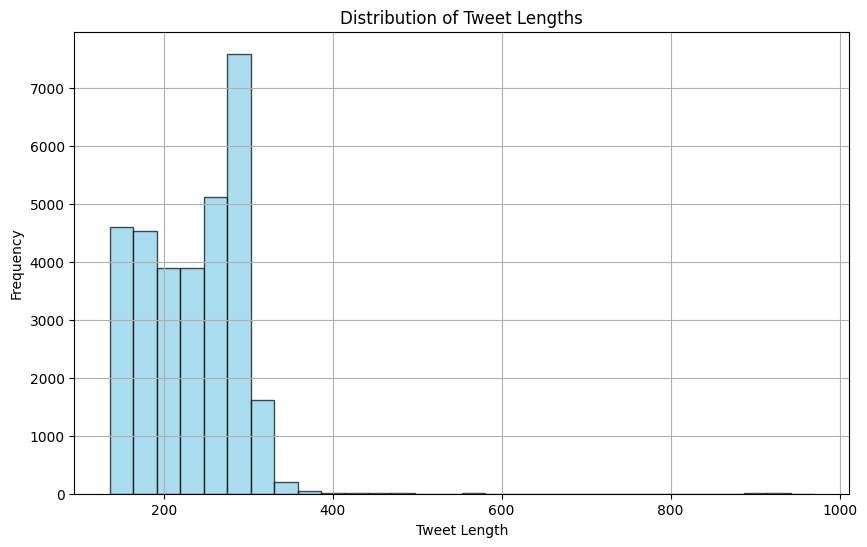

In [ ]:
tweet_lengths = mental_df['tweet'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Distribution of Sentiment Scores

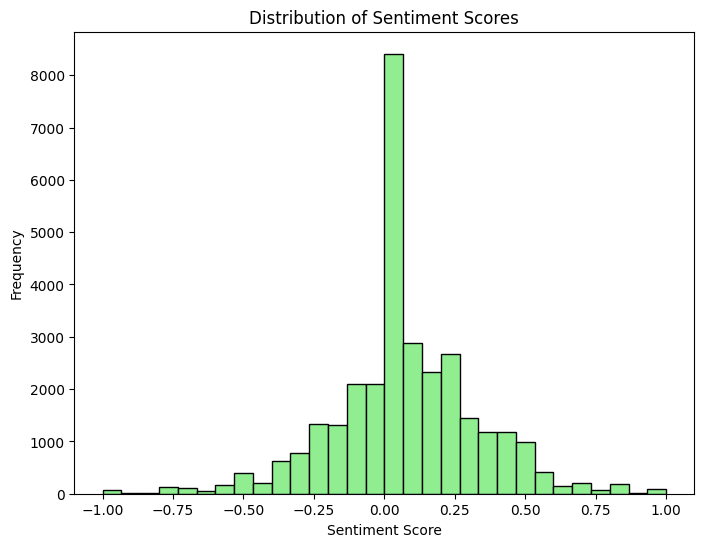

In [ ]:
def get_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

mental_df['sentiment'] = mental_df['clean_tweet'].apply(get_sentiment)
plt.figure(figsize=(8, 6))
plt.hist(mental_df['sentiment'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()
mental_df.drop(columns=['sentiment'], inplace=True)

### Word Cloud

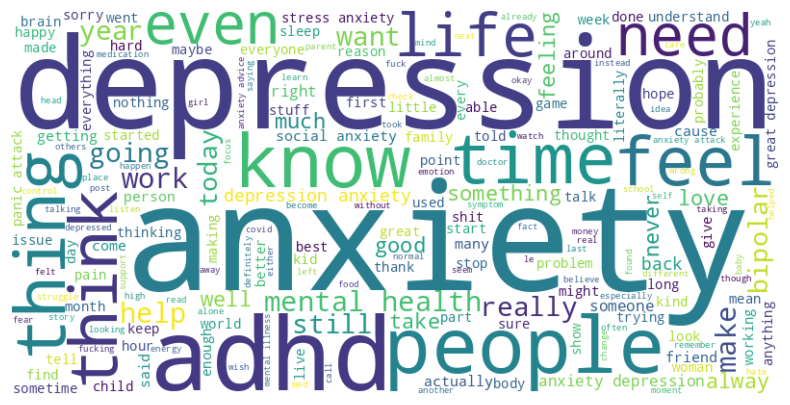

In [ ]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
clean_tweets_text = ' '.join(mental_df['clean_tweet'].values)
generate_wordcloud(clean_tweets_text)

### Top 10 Most Common Words

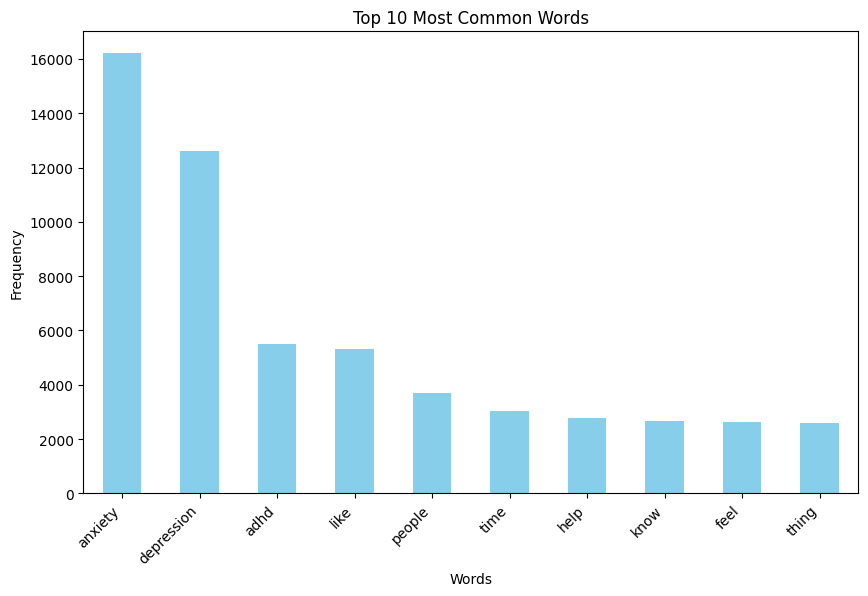

In [ ]:
def plot_top_words(text, n=10):
    words = text.split()
    word_counts = pd.Series(words).value_counts()
    top_words = word_counts.head(n)
    plt.figure(figsize=(10, 6))
    top_words.plot(kind='bar', color='skyblue')
    plt.title(f'Top {n} Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()
clean_tweets_text = ' '.join(mental_df['clean_tweet'].values)
plot_top_words(clean_tweets_text, n=10)

### Top 10 Most Common Phrases(Bi-Grams)

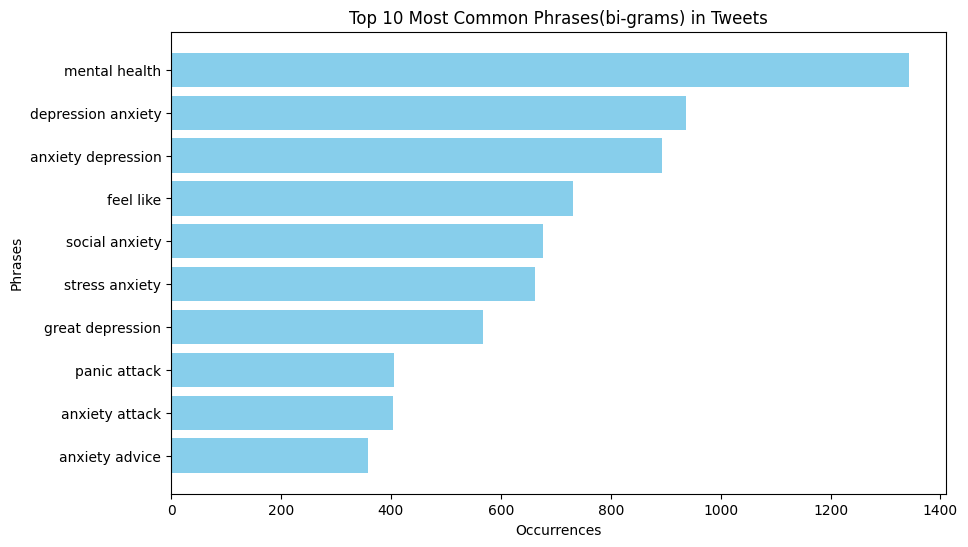

In [ ]:
def extract_phrases(text, n=2):
    words = re.findall(r'\b\w+\b', text.lower())
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

all_clean_tweets = ' '.join(mental_df['clean_tweet'])
all_phrases = extract_phrases(all_clean_tweets)
phrase_counts = Counter(all_phrases)
top_10_phrases = phrase_counts.most_common(10)
top_phrases, phrase_counts = zip(*top_10_phrases)
plt.figure(figsize=(10, 6))
plt.barh(top_phrases, phrase_counts, color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Phrases')
plt.title('Top 10 Most Common Phrases(bi-grams) in Tweets')
plt.gca().invert_yaxis()
plt.show()

###  Top 10 Most Common Phrases(Tri-Grams)

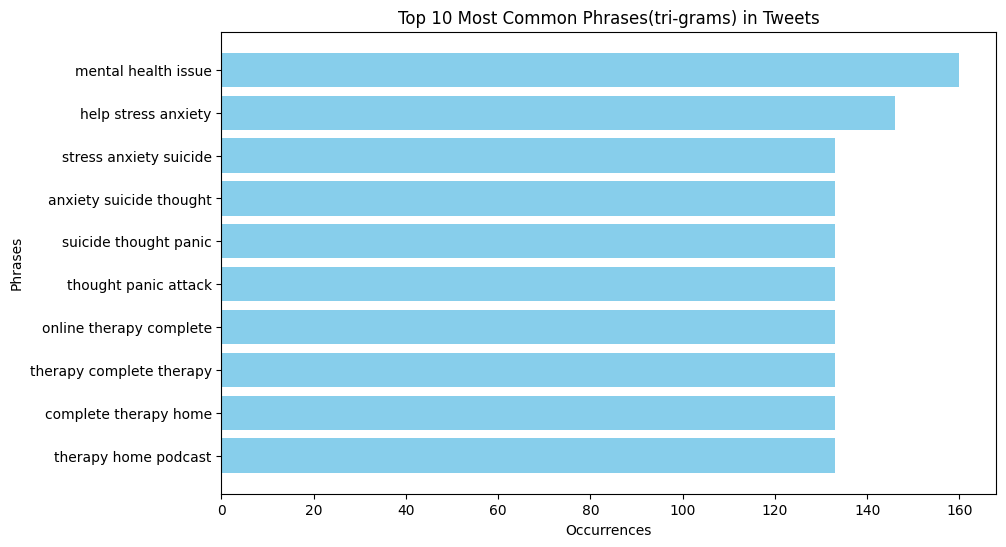

In [ ]:
def extract_phrases(text, n=3):
    words = re.findall(r'\b\w+\b', text.lower())
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

all_clean_tweets = ' '.join(mental_df['clean_tweet'])
all_phrases = extract_phrases(all_clean_tweets)
phrase_counts = Counter(all_phrases)
top_10_phrases = phrase_counts.most_common(10)
top_phrases, phrase_counts = zip(*top_10_phrases)
plt.figure(figsize=(10, 6))
plt.barh(top_phrases, phrase_counts, color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Phrases')
plt.title('Top 10 Most Common Phrases(tri-grams) in Tweets')
plt.gca().invert_yaxis()
plt.show()

# Models

## Predicting based on Bert Model




In [ ]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=6)

## Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to encode the tweets and perform classification
def classify_tweet(tweet):
    inputs = tokenizer(tweet, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']
    return labels[predicted_class]

mental_df['label'] = mental_df['clean_tweet'].apply(lambda x: classify_tweet(x))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
mental_df.head()

tweet       label  \
0  @classpass Of course, I’ll do a couple more ra...  depression   
1  @zjldlwn To TNX: \nI might have been attracted...  depression   
2  @Misses_Sniper77 @SavviiAnna I have to compart...  depression   
3  Sorry but last night's anxiety dream was that ...  depression   
4  #TikTok Ya just gotta dance to the #anxiety go...     anxiety   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_Bert.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_Bert.csv")

###  Check the distribution of labels


In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
depression    26052
normal         3899
anxiety        1642
adhd             11
Name: count, dtype: int64


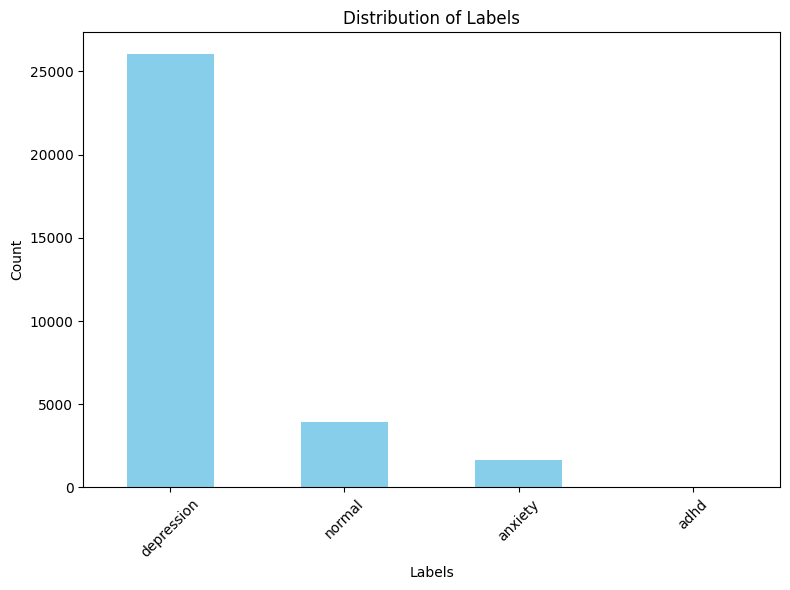

In [ ]:
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predicting based on DistilBERT Model

In [ ]:
# Load the pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=6)

## Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Enable automatic mixed precision training
scaler = torch.cuda.amp.GradScaler()

def classify_tweet(tweet: str) -> str:
    inputs = tokenizer(tweet, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU
    with torch.cuda.amp.autocast():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']
    return labels[predicted_class]

mental_df['label'] = mental_df['clean_tweet'].apply(lambda x: classify_tweet(x))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
mental_df.head()

tweet   label  \
0  @classpass Of course, I’ll do a couple more ra...    adhd   
1  @zjldlwn To TNX: \nI might have been attracted...    adhd   
2  @Misses_Sniper77 @SavviiAnna I have to compart...    pdsd   
3  Sorry but last night's anxiety dream was that ...    pdsd   
4  #TikTok Ya just gotta dance to the #anxiety go...  normal   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_DistilBERT.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_DistilBERT.csv")

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
adhd      24797
pdsd       4627
normal     2180
Name: count, dtype: int64


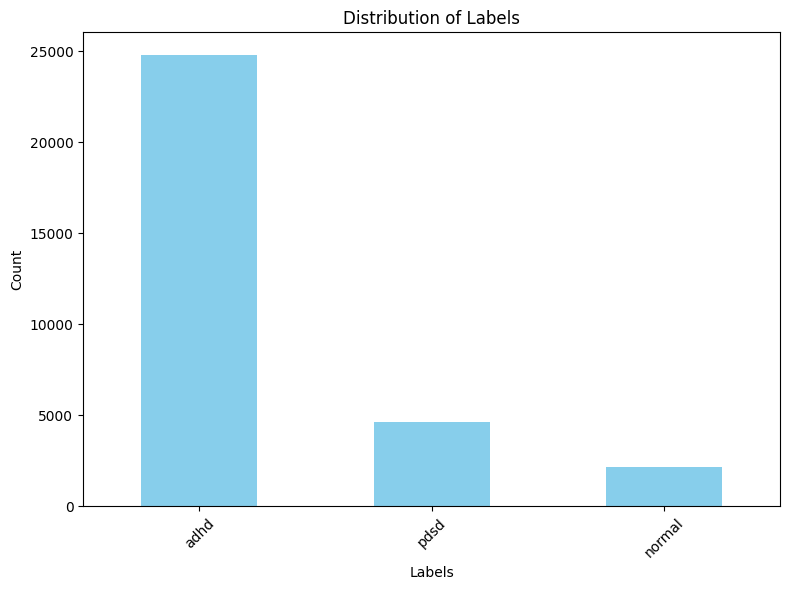

In [ ]:
label_distribution = mental_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predicting based on XLNet Model

In [ ]:
# Load the pre-trained XLNet model and tokenizer
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=6)

## Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to encode the tweets and perform classification
def classify_tweet(tweet):
    inputs = tokenizer(tweet, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']
    return labels[predicted_class]

mental_df['label'] = mental_df['clean_tweet'].apply(lambda x: classify_tweet(x))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
mental_df.head()

tweet    label  \
0  @classpass Of course, I’ll do a couple more ra...     pdsd   
1  @zjldlwn To TNX: \nI might have been attracted...     adhd   
2  @Misses_Sniper77 @SavviiAnna I have to compart...     adhd   
3  Sorry but last night's anxiety dream was that ...  anxiety   
4  #TikTok Ya just gotta dance to the #anxiety go...     pdsd   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_XLNet.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_XLNet.csv")

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
pdsd          20088
anxiety        7767
normal         1959
adhd           1650
depression      111
bipolar          29
Name: count, dtype: int64


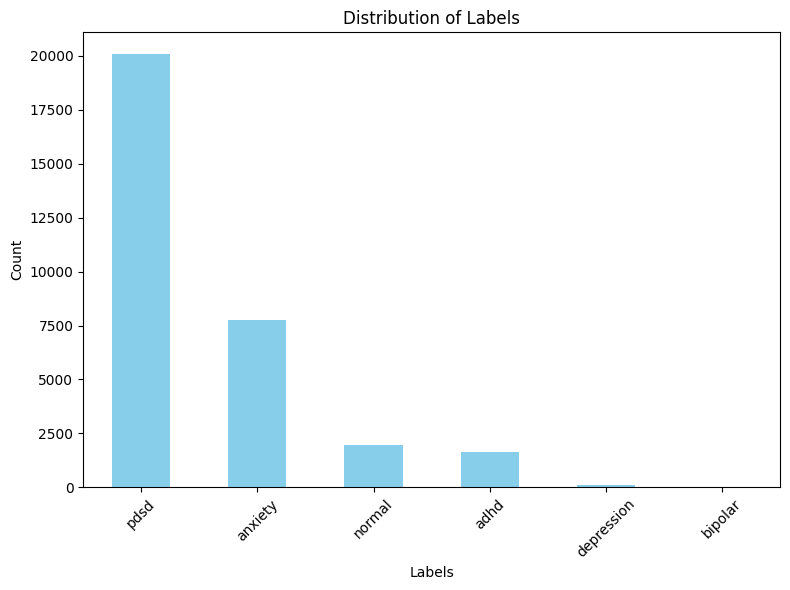

In [ ]:
label_distribution = mental_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predicting based on Zero Shot Classification


In [ ]:
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("zero-shot-classification", device=device)

labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

def classify_tweet(row):
    result = classifier(row['clean_tweet'], labels)
    max_label = result['labels'][0]
    return max_label

mental_df['label'] = mental_df.apply(classify_tweet, axis=1)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
mental_df.head()

tweet    label  \
0  @classpass Of course, I’ll do a couple more ra...  anxiety   
1  @zjldlwn To TNX: \nI might have been attracted...  anxiety   
2  @Misses_Sniper77 @SavviiAnna I have to compart...  anxiety   
3  Sorry but last night's anxiety dream was that ...  anxiety   
4  #TikTok Ya just gotta dance to the #anxiety go...  anxiety   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_zeroshot.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_zeroshot.csv")

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
anxiety       13679
depression    10546
adhd           5052
bipolar        1710
pdsd            439
normal          178
Name: count, dtype: int64


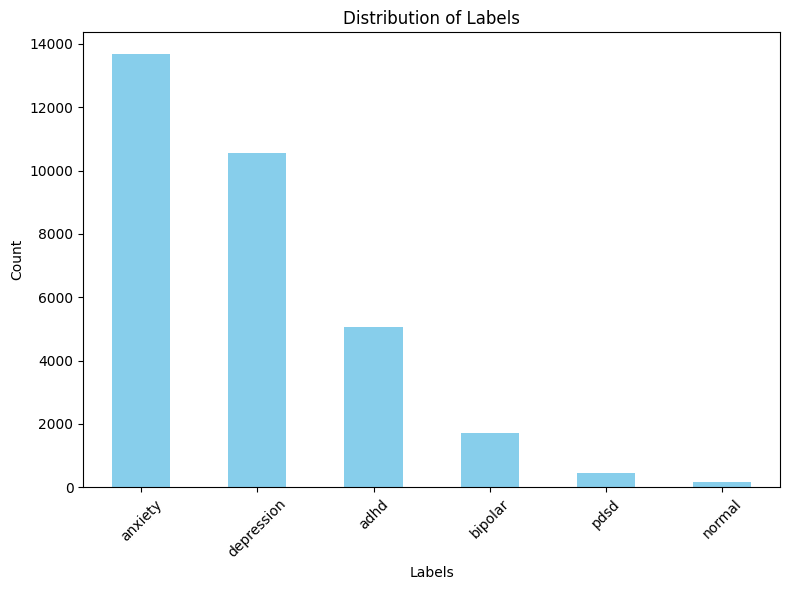

In [ ]:
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predicting based on GPT 2 Model

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=6)

## Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to encode the tweets and perform classification
def classify_tweet(tweet):
    if pd.isnull(tweet) or not tweet.strip():
        return "anxiety"
    else:
        inputs = tokenizer(tweet, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        predicted_class = torch.argmax(outputs.logits).item()
        labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']
        return labels[predicted_class]

mental_df['label'] = mental_df['clean_tweet'].apply(lambda x: classify_tweet(x))

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
mental_df.head()

tweet    label  \
0  @classpass Of course, I’ll do a couple more ra...  anxiety   
1  @zjldlwn To TNX: \nI might have been attracted...  anxiety   
2  @Misses_Sniper77 @SavviiAnna I have to compart...  anxiety   
3  Sorry but last night's anxiety dream was that ...  anxiety   
4  #TikTok Ya just gotta dance to the #anxiety go...     pdsd   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_GPT2.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_GPT2.csv")

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
anxiety       30222
pdsd           1380
depression        2
Name: count, dtype: int64


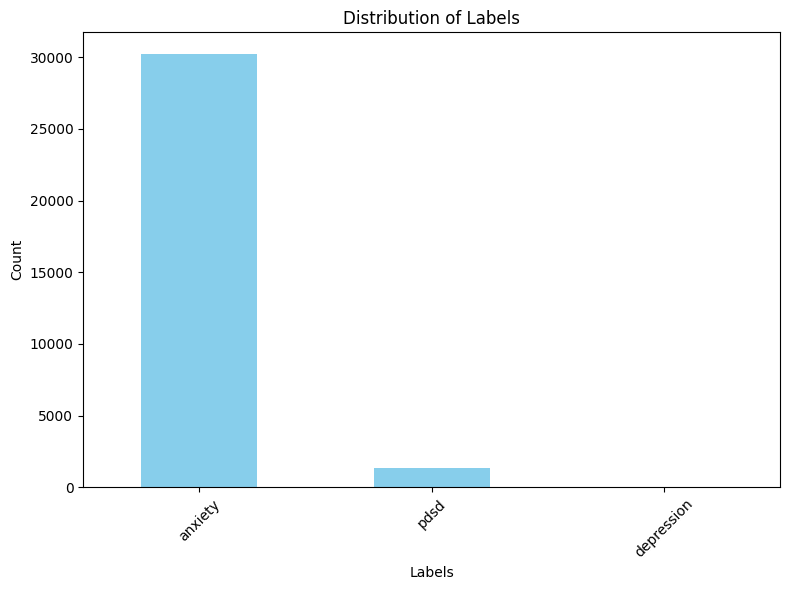

In [ ]:
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predicting based on Openai Api (Limited Requests) Don't Use

In [ ]:
from openai import OpenAI
client = OpenAI(
    api_key="sk-proj-g8sW6o4KOQh0KQpNq7A6T3BlbkFJJ4padDRccY5KVE3l1DGT"
)


def classify_tweet(text):
    prompt = f"Classify the following text: {text} only from these labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']"
    response = client.completions.create(
                        model="gpt-3.5-turbo-instruct",
                        prompt=prompt
                        )
    print(response.choices[0].text)

# Example usage
mental_df['label'] = mental_df['clean_tweet'][:1].apply(classify_tweet)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

## Predicting based on Gemini Api (Limited Requests) Don't Use

In [ ]:
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

def classify_tweet(text):
    model = genai.GenerativeModel('gemini-pro')
    prompt = f"Classify the following text: {text} only from these labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']"
    response = model.generate_content(prompt)
    if response.parts:
        return response.text
    else:
        print("Response does not contain a valid part.")
        print("Response:", response)
        return None


mental_df['label'] = mental_df['clean_tweet'][:15].apply(lambda x: classify_tweet(x))

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_gemini_15.csv', index=False)

### Loading the Saved CSV

In [ ]:
classified_tweet_gemini_15 = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_gemini_15.csv")
classified_tweet_gemini_15.head(20)

tweet       label  \
0   @classpass Of course, I’ll do a couple more ra...     anxiety   
1   @zjldlwn To TNX: \nI might have been attracted...     anxiety   
2   @Misses_Sniper77 @SavviiAnna I have to compart...     anxiety   
3   Sorry but last night's anxiety dream was that ...     anxiety   
4   #TikTok Ya just gotta dance to the #anxiety go...     anxiety   
5   @PGtzsche1 Nemeroff was found to be grotesquel...     bipolar   
6   @Lise_dsf1 Ok this isn’t a relaxing tool but I...        adhd   
7   @CaraLisette had one of mine out a while ago. ...  depression   
8   the month of may was a whole event! diagnosed ...        adhd   
9   @bottomfragbarb That was a good tweet....good ...        adhd   
10  @NftCelestials im very sensitive to the whole ...        adhd   
11  @No7Sammy All the best Sam and very well done ...  depression   
12  @IrramIrshad1 I am having an anxiety attack ju...     anxiety   
13  @CNN That frankly astounded me. Women traditio...  depression   
14  My anxiety will be really high today and tomor...     anxiety   
15  @KatinkaTheKat @AlexisDeise @MollyJongFast @Bi...         NaN   
16  @fruitybeatles exactly lol like is paul mccart...         NaN   
17  Koncentracja i skupienie w czasie pracy - maci...         NaN   
18  Grief is a whole range of emotions which inclu...         NaN   
19  お知らせ🌟\n風呂上がり、10時ぐらいににスペースやります‼️😄\n誰でも歓迎！\nぜひ参加...         NaN   

                                          clean_tweet  
0   course couple rapid test day get home sure saf...  
1   TNX might attracted first look talent happy me...  
2   compartmentalize planning separate list placed...  
3   Sorry last night anxiety dream direct producti...  
4   TikTok got dance anxiety god hope TAKE AWAY Ro...  
5   Nemeroff found grotesquely dishonest popularis...  
6   relaxing tool Ive really bad stress recently a...  
7   one mine ago Dentist lovely gave great numbing...  
8   month may whole event diagnosed adhd possibly ...  
9   That good tweet .... good realistic advice ......  
10  sensitive whole parent know whats best kid thi...  
11  All best Sam well done getting help There stil...  
12  anxiety attack listening diazepam relatively s...  
13  That frankly astounded Women traditionally use...  
14  anxiety really high today tomorrow kinda wish ...  
15  Yes work healthcare support right-to-die movem...  
16  exactly lol like paul mccartney hanging every ...  
17  Koncentracja skupienie czasie pracy macie tym ...  
18  Grief whole range emotion includes deep profou...  
19  お知らせ🌟 風呂上がり、時ぐらいににスペースやります‼️😄 誰でも歓迎！ ぜひ参加してくださ...

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

In [ ]:
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predicting Based on LDA

In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('lda', LatentDirichletAllocation(n_components=6, random_state=42)),
    ('kmeans', KMeans(n_clusters=6, random_state=42))
])

pipeline.fit(mental_df['clean_tweet'])
mental_df['label'] = pipeline.predict(mental_df['clean_tweet'])
cluster_label_mapping = {
    0: 'depression',
    1: 'anxiety',
    2: 'adhd',
    3: 'pdsd',
    4: 'bipolar',
    5: 'normal'
}
mental_df['label'] = mental_df['label'].map(cluster_label_mapping)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
mental_df.head()

tweet       label  \
0  @classpass Of course, I’ll do a couple more ra...  depression   
1  @zjldlwn To TNX: \nI might have been attracted...  depression   
2  @Misses_Sniper77 @SavviiAnna I have to compart...  depression   
3  Sorry but last night's anxiety dream was that ...  depression   
4  #TikTok Ya just gotta dance to the #anxiety go...  depression   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_lda.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_lda.csv")

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
depression    26071
bipolar        1595
anxiety        1421
pdsd            896
normal          813
adhd            808
Name: count, dtype: int64


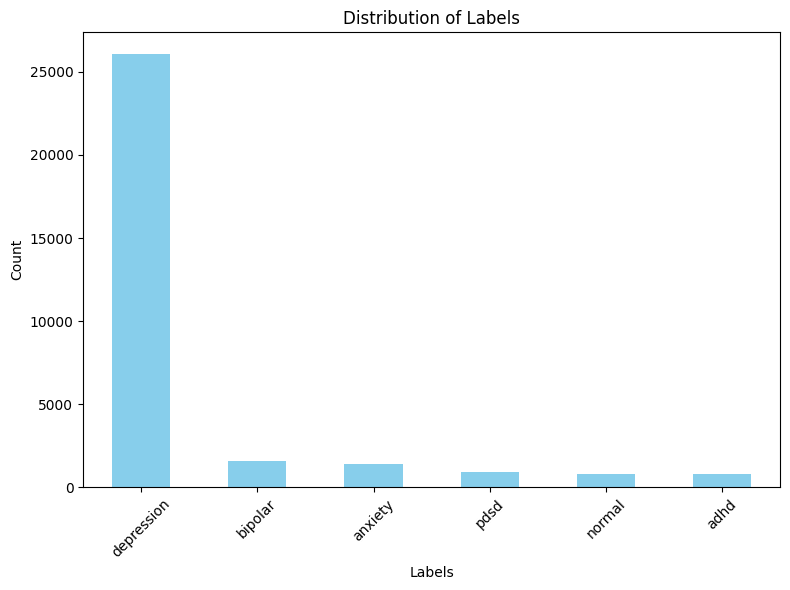

In [ ]:
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predicting Based on NMF

In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('nmf', NMF(n_components=6, random_state=42)),
    ('kmeans', KMeans(n_clusters=6, random_state=42))
])

pipeline.fit(mental_df['clean_tweet'])
mental_df['label'] = pipeline.predict(mental_df['clean_tweet'])
cluster_label_mapping = {
    0: 'depression',
    1: 'anxiety',
    2: 'adhd',
    3: 'pdsd',
    4: 'bipolar',
    5: 'normal'
}
mental_df['label'] = mental_df['label'].map(cluster_label_mapping)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
mental_df.head()

tweet       label  \
0  @classpass Of course, I’ll do a couple more ra...  depression   
1  @zjldlwn To TNX: \nI might have been attracted...  depression   
2  @Misses_Sniper77 @SavviiAnna I have to compart...  depression   
3  Sorry but last night's anxiety dream was that ...  depression   
4  #TikTok Ya just gotta dance to the #anxiety go...  depression   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_nmf.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_nmf.csv")

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
depression    28540
bipolar        1980
anxiety         459
adhd            384
pdsd            133
normal          108
Name: count, dtype: int64


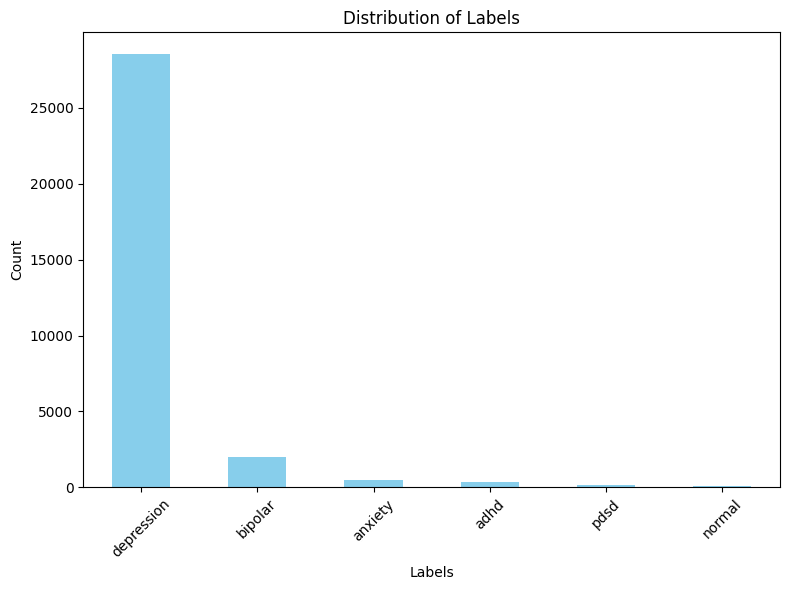

In [ ]:
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Classify Tweets Based on Occurrence of Label Terms

In [ ]:
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']
lemmatizer = WordNetLemmatizer()

# Function to classify tweets based on occurrence of label terms
def classify_tweet(row):
    tweet_tokens = nltk.word_tokenize(row['clean_tweet'].lower())
    label_counts = {label: sum(1 for token in tweet_tokens if lemmatizer.lemmatize(token) == label) for label in labels}
    if all(count == 0 for count in label_counts.values()):
        return 'normal'
    max_label = max(label_counts, key=label_counts.get)
    return max_label

mental_df['label'] = mental_df.apply(classify_tweet, axis=1)

In [ ]:
mental_df.head()

tweet    label  \
0  @classpass Of course, I’ll do a couple more ra...  anxiety   
1  @zjldlwn To TNX: \nI might have been attracted...  anxiety   
2  @Misses_Sniper77 @SavviiAnna I have to compart...  anxiety   
3  Sorry but last night's anxiety dream was that ...  anxiety   
4  #TikTok Ya just gotta dance to the #anxiety go...  anxiety   

                                         clean_tweet  
0  course couple rapid test day home sure safe hu...  
1  might attracted first look talent happy meet b...  
2  compartmentalize planning separate list placed...  
3  sorry last night anxiety dream direct producti...  
4  tiktok dance anxiety god hope take away rofu j...

### Saving the classified tweets

In [ ]:
mental_df.to_csv('/content/drive/MyDrive/mental illness classification/classified_tweet_basic.csv', index=False)

### Loading the Saved CSV

In [ ]:
mental_df = pd.read_csv("/content/drive/MyDrive/mental illness classification/classified_tweet_basic.csv")

### Check the distribution of labels

In [ ]:
label_distribution = mental_df['label'].value_counts()
print(label_distribution)

label
anxiety       12911
depression    11689
adhd           4474
bipolar        1466
normal         1063
pdsd              1
Name: count, dtype: int64


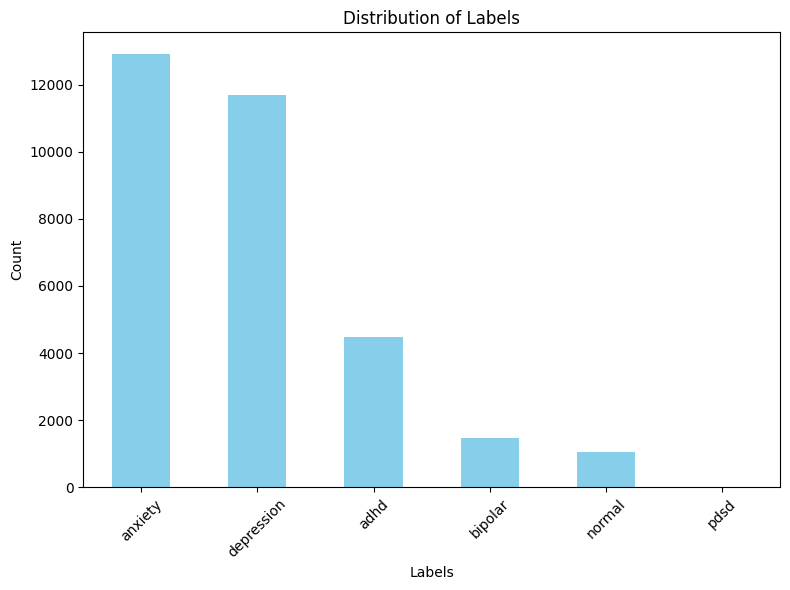

In [ ]:
plt.figure(figsize=(8,6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparisons

## Loading Model Output CSV files


In [ ]:
csv_files = {
    'Bert': '/content/drive/MyDrive/mental illness classification/classified_tweet_Bert.csv',
    'Distilbert': '/content/drive/MyDrive/mental illness classification/classified_tweet_DistilBERT.csv',
    'Xlnet': '/content/drive/MyDrive/mental illness classification/classified_tweet_XLNet.csv',
    'Zero_Shot': '/content/drive/MyDrive/mental illness classification/classified_tweet_zeroshot.csv',
    'GPT2' : '/content/drive/MyDrive/mental illness classification/classified_tweet_GPT2.csv',
    'LDA': '/content/drive/MyDrive/mental illness classification/classified_tweet_lda.csv',
    'NMF': '/content/drive/MyDrive/mental illness classification/classified_tweet_nmf.csv',
    'Basic_Model': '/content/drive/MyDrive/mental illness classification/classified_tweet_basic.csv'
    # Add more CSV files as needed
}

dfs = {name: pd.read_csv(file) for name, file in csv_files.items()}

## Label Comparisons between the Models in pair


### ***model_1 vs model_2***  means ***With Respect To model_1 Predicted Labels Comparisons For model_2 Predicted Labels***

In [ ]:
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar', 'normal']

# Initializing dictionaries to store counts
same_label = {label: 0 for label in labels}
diff_label = {label: 0 for label in labels}
total_counts = {label: 0 for label in labels}

# Create a dictionary to store the pairwise comparison data
pairwise_comparisons = {}

for model1, df1 in dfs.items():
    for model2, df2 in dfs.items():
        if model1 != model2:
            pair_key = f"{model1} vs {model2}"
            pair_same_label = {label: 0 for label in labels}
            pair_diff_label = {label: 0 for label in labels}
            pair_total_counts = {label: 0 for label in labels}

            # Create a dictionary for quick tweet to label lookup for df2
            tweet_to_label2 = dict(zip(df2['tweet'], df2['label']))

            for index, row in df1.iterrows():
                tweet = row['tweet']
                label = row['label']

                # If the same tweet exists in df2
                if tweet in tweet_to_label2:
                    label2 = tweet_to_label2[tweet]

                    # Updating counts based on label comparison
                    if label == label2:
                        pair_same_label[label] += 1
                        same_label[label] += 1
                    else:
                        pair_diff_label[label] += 1
                        diff_label[label] += 1
                    pair_total_counts[label] += 1
                    total_counts[label] += 1

            pairwise_comparisons[pair_key] = {
                'same_label': pair_same_label,
                'diff_label': pair_diff_label,
                'total_counts': pair_total_counts
            }

# Display the results
for pair_key, data in pairwise_comparisons.items():
    headers = ["Count/Label"] + labels + ["Total"]
    same_label_data = data['same_label']
    diff_label_data = data['diff_label']
    total_counts_data = data['total_counts']

    rows = [
        ["Same Label Counts:"] + [same_label_data[label] for label in labels] + [sum(same_label_data.values())],
        ["Different Label Counts:"] + [diff_label_data[label] for label in labels] + [sum(diff_label_data.values())],
        ["Total Counts:"] + [total_counts_data[label] for label in labels] + [sum(total_counts_data.values())]
    ]

    print(f"{pair_key}:\n")
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    print("\n")

Bert vs Distilbert:

+-------------------------+--------------+-----------+--------+--------+-----------+----------+---------+
| Count/Label             |   depression |   anxiety |   adhd |   pdsd |   bipolar |   normal |   Total |
+=========================+==============+===========+========+========+===========+==========+=========+
| Same Label Counts:      |            0 |         0 |     11 |      0 |         0 |      340 |     351 |
+-------------------------+--------------+-----------+--------+--------+-----------+----------+---------+
| Different Label Counts: |        26052 |      1642 |      0 |      0 |         0 |     3559 |   31253 |
+-------------------------+--------------+-----------+--------+--------+-----------+----------+---------+
| Total Counts:           |        26052 |      1642 |     11 |      0 |         0 |     3899 |   31604 |
+-------------------------+--------------+-----------+--------+--------+-----------+----------+---------+


Bert vs Xlnet:

+------

## Comparative Analysis of Other Models vs. Basic Model

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'Basic_Model':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['Basic_Model'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+------------+----------------+-----------------+--------------+----------------+
| Model      |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+============+================+=================+==============+================+
| Bert       |        33.6192 |        36.7511  |      33.6192 |        23.1241 |
+------------+----------------+-----------------+--------------+----------------+
| Distilbert |        10.8594 |         2.08858 |      10.8594 |         3.4669 |
+------------+----------------+-----------------+--------------+----------------+
| Xlnet      |        11.2264 |        31.4675  |      11.2264 |        14.1162 |
+------------+----------------+-----------------+--------------+----------------+
| Zero_Shot  |        91.2131 |        91.5288  |      91.2131 |        90.736  |
+------------+----------------+-----------------+--------------+----------------+
| GPT2       |        39.5393 |        35.383   |      39.5393 |        23.675  |
+------------+--

In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Basic_Model':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['Basic_Model'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for Bert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0.38 |     0.84 |       0.52 |
+------------+-------------+----------+------------+
| anxiety    |        0.4  |     0.05 |       0.09 |
+------------+-------------+----------+------------+
| adhd       |        0.45 |     0    |       0    |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| normal     |        0.05 |     0.17 |       0.07 |
+------------+-------------+----------+------------+

Classification Report for Distilbert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============

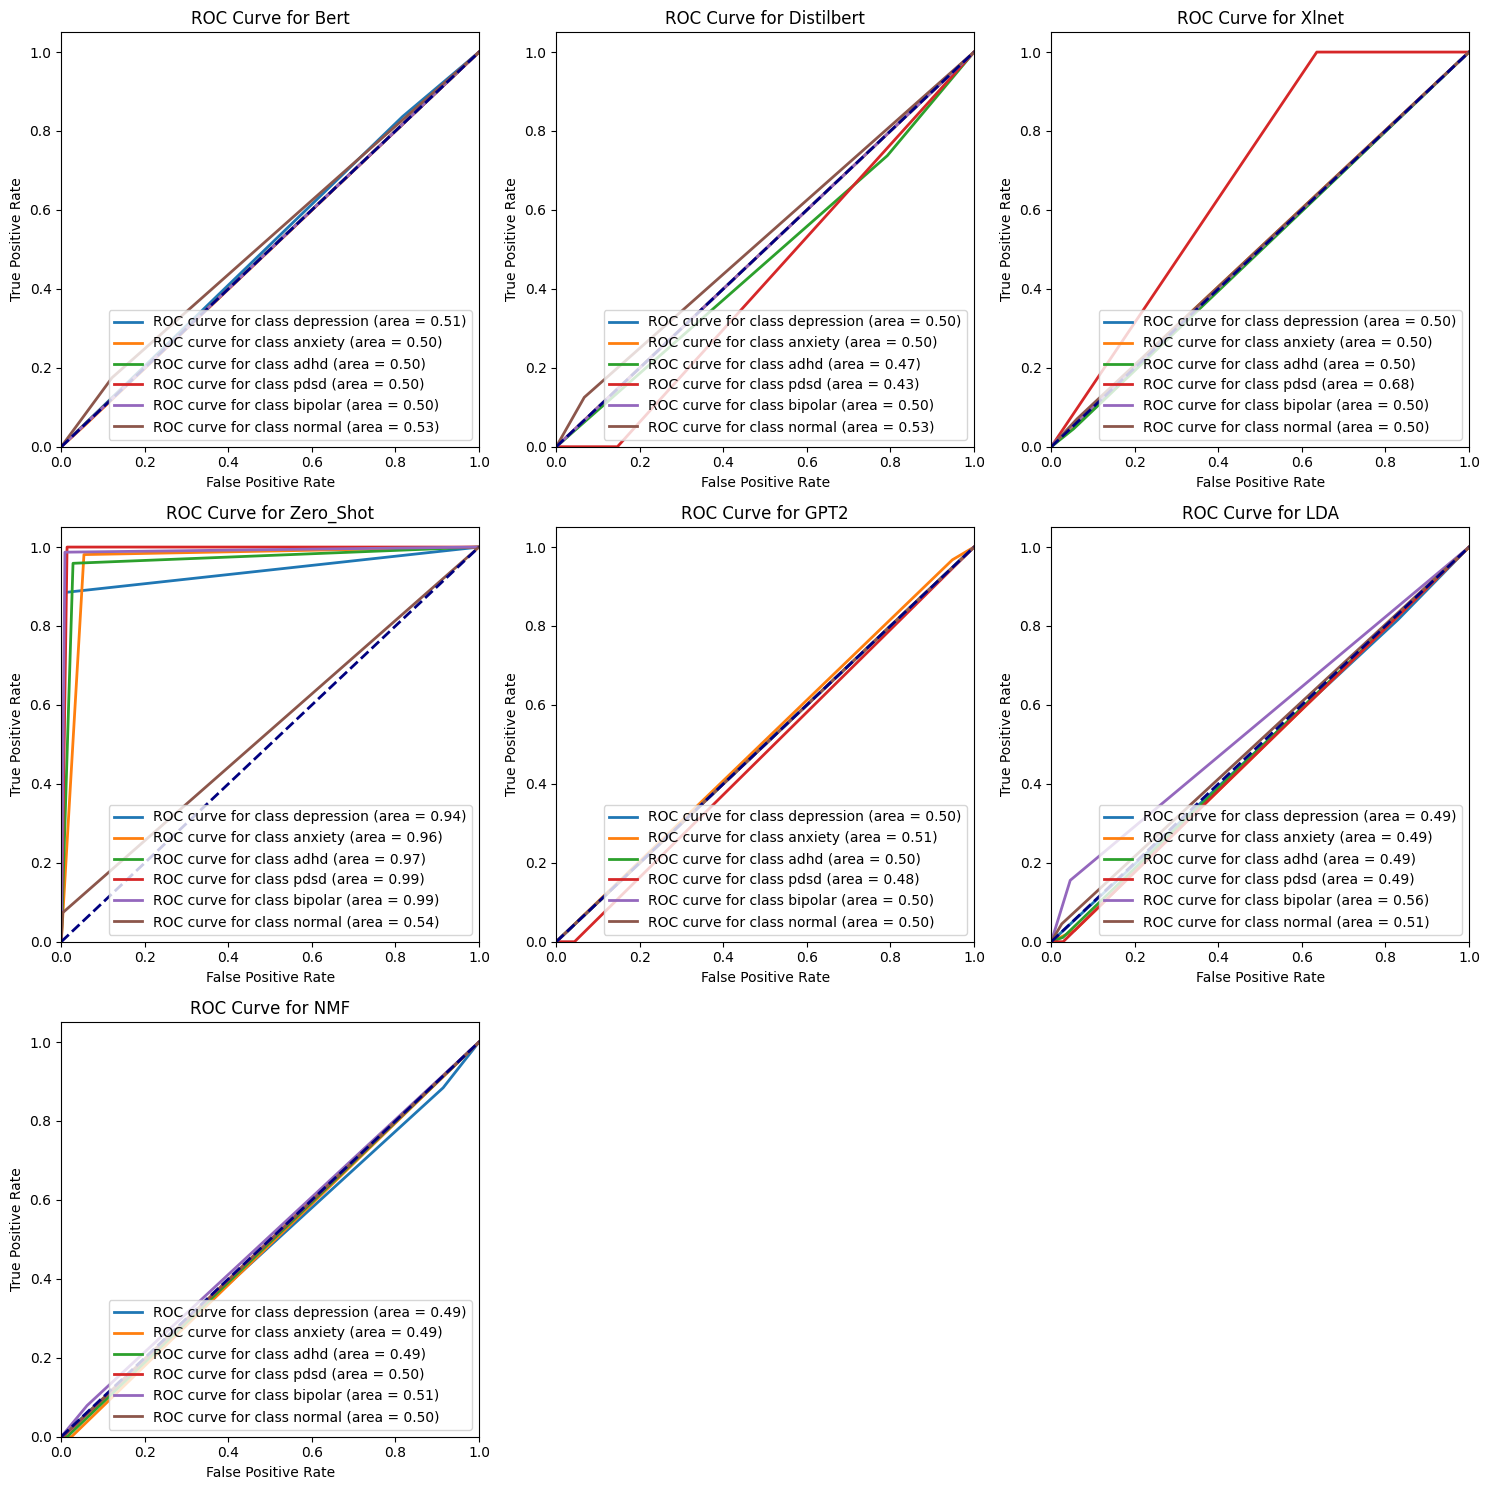

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'Basic_Model':
        plot_roc_curve(axes[index], model_name, dfs['Basic_Model']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

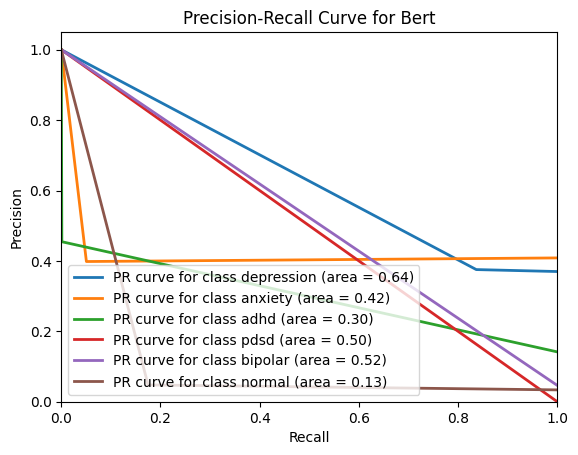

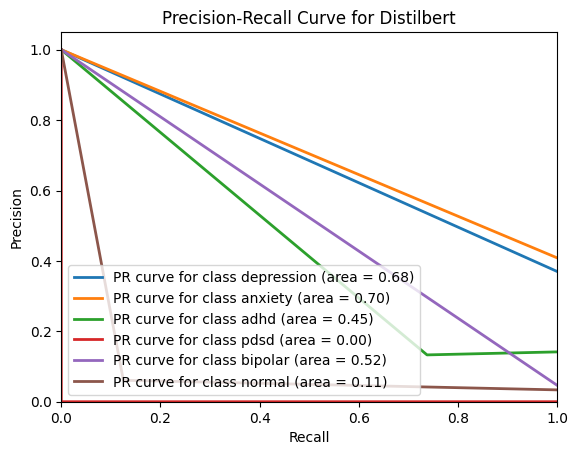

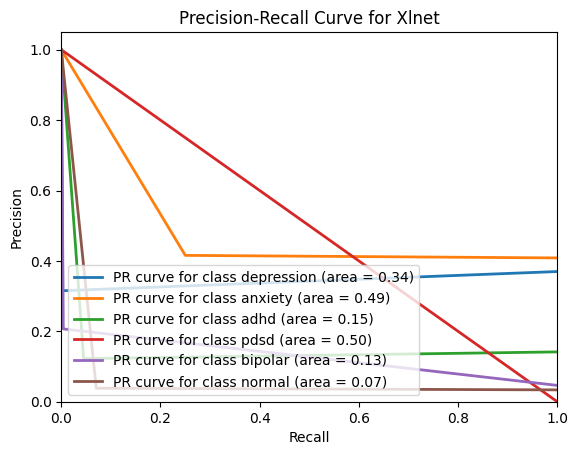

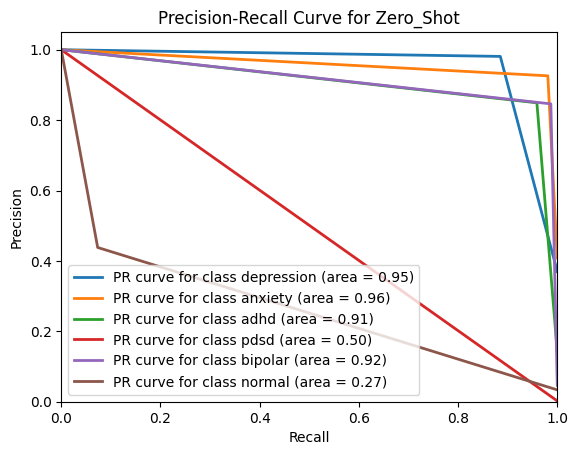

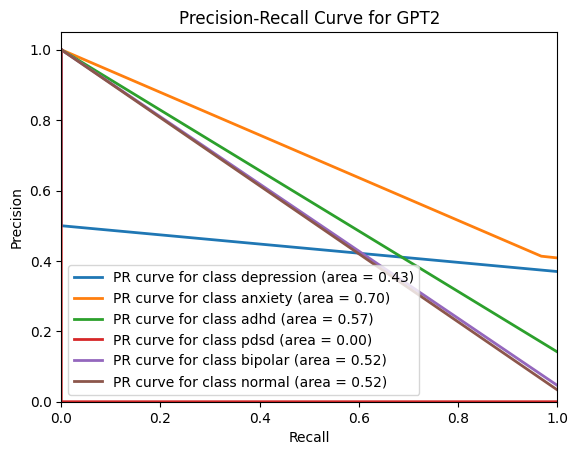

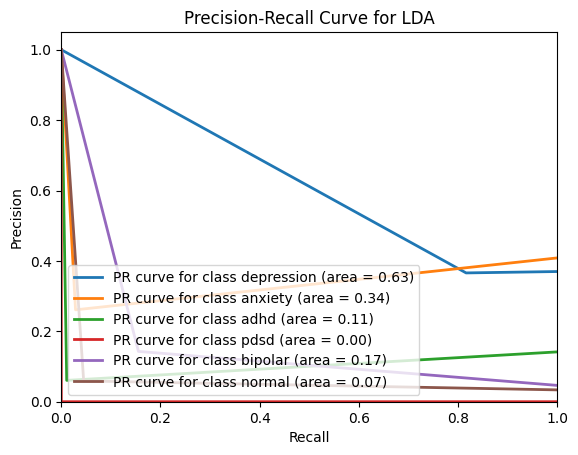

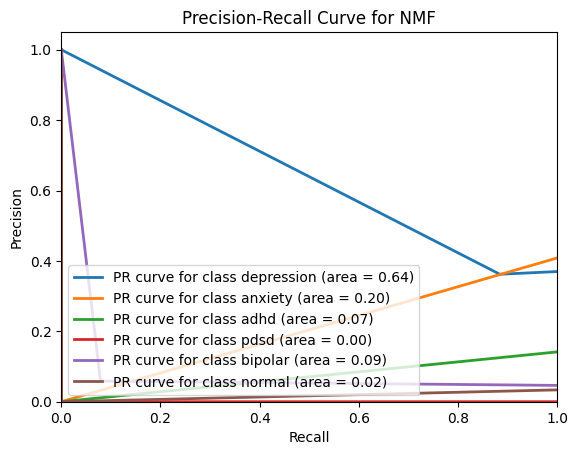

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Basic_Model':
        plot_pr_curve(model_name, dfs['Basic_Model'], model_df, labels)

## Comparative Analysis of Other Models vs. Bert Model

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'Bert':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['Bert'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-

+-------------+----------------+-----------------+--------------+----------------+
| Model       |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+=============+================+=================+==============+================+
| Distilbert  |        1.11062 |         1.92414 |      1.11062 |        1.38006 |
+-------------+----------------+-----------------+--------------+----------------+
| Xlnet       |        2.73067 |        68.6714  |      2.73067 |        2.14801 |
+-------------+----------------+-----------------+--------------+----------------+
| Zero_Shot   |       29.9741  |        70.727   |     29.9741  |       40.0604  |
+-------------+----------------+-----------------+--------------+----------------+
| GPT2        |        5.02468 |        41.4891  |      5.02468 |        0.52386 |
+-------------+----------------+-----------------+--------------+----------------+
| LDA         |       68.0642  |        68.8806  |     68.0642  |       68.2102  |
+---

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Bert':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['Bert'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.


Classification Report for Distilbert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| anxiety    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| adhd       |        0    |     1    |       0    |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| normal     |        0.16 |     0.09 |       0.11 |
+------------+-------------+----------+------------+

Classification Report for Xlnet:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

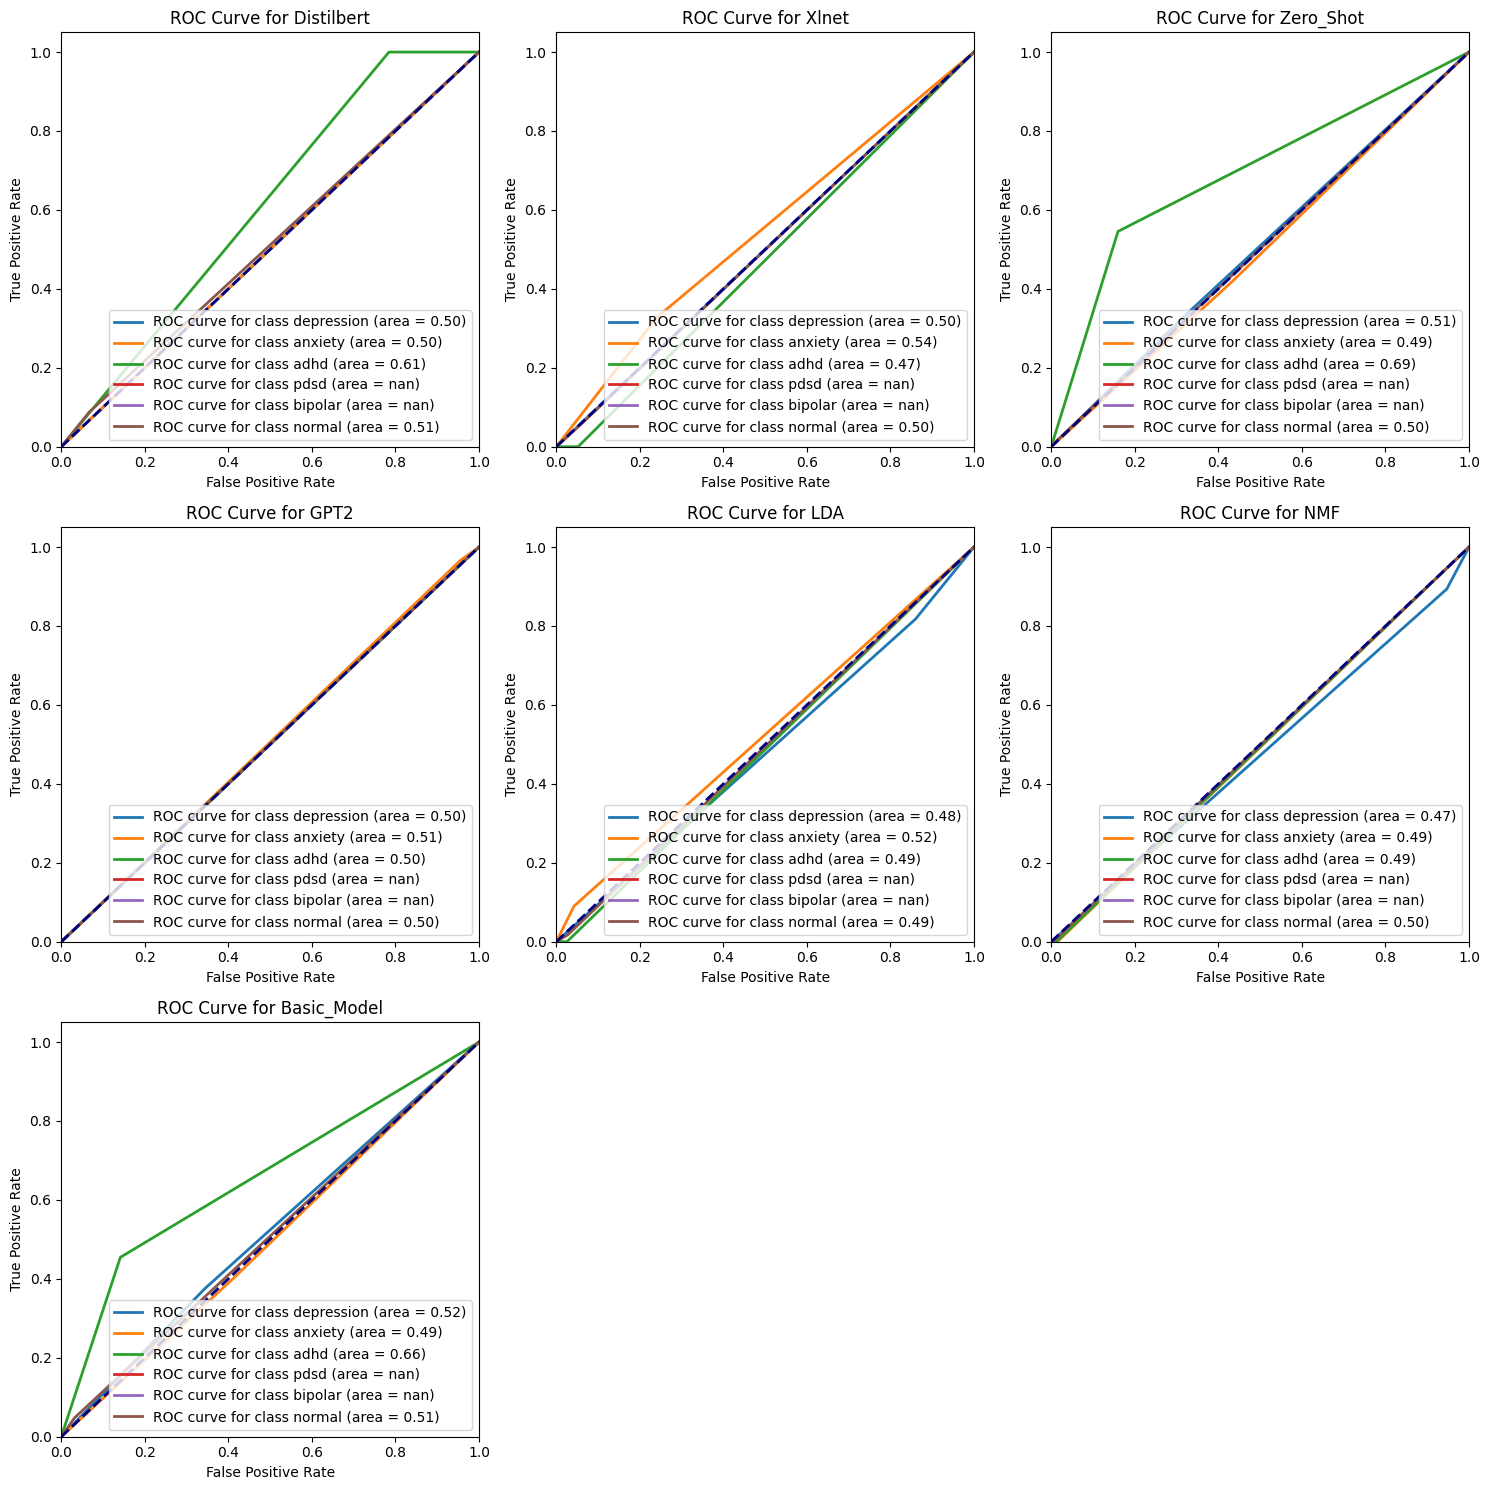

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'Bert':
        plot_roc_curve(axes[index], model_name, dfs['Bert']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


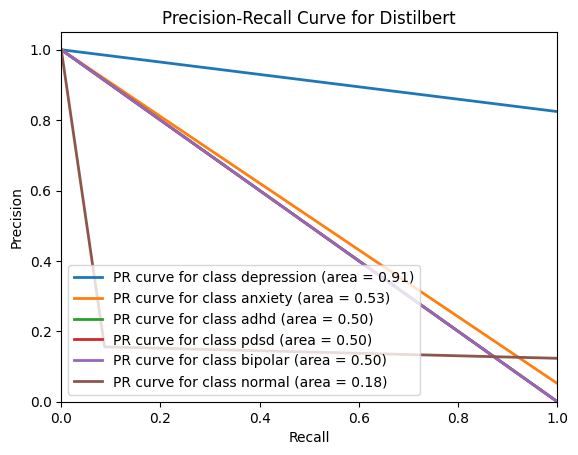

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


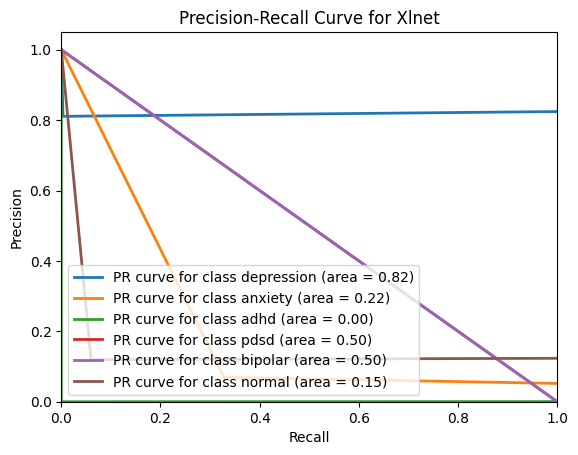

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


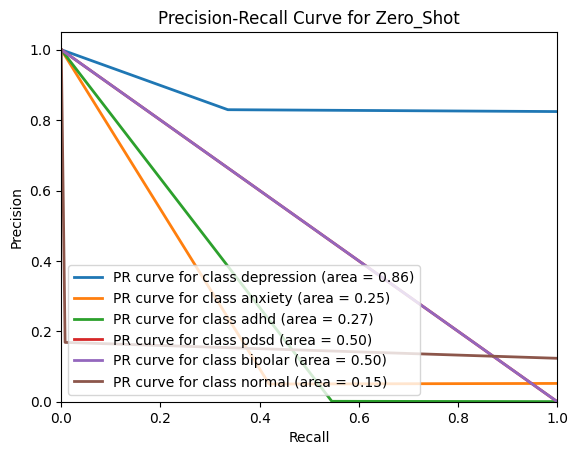

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


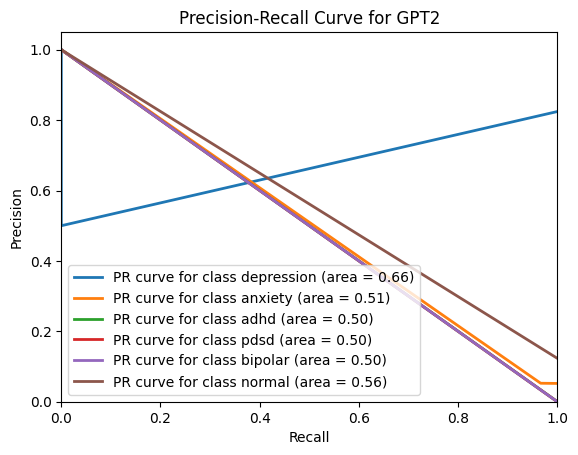

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


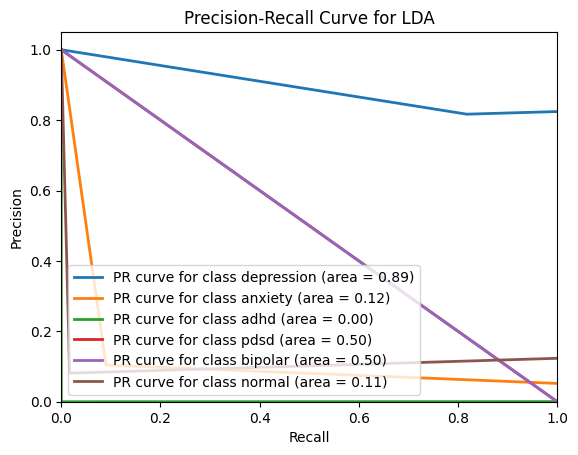

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


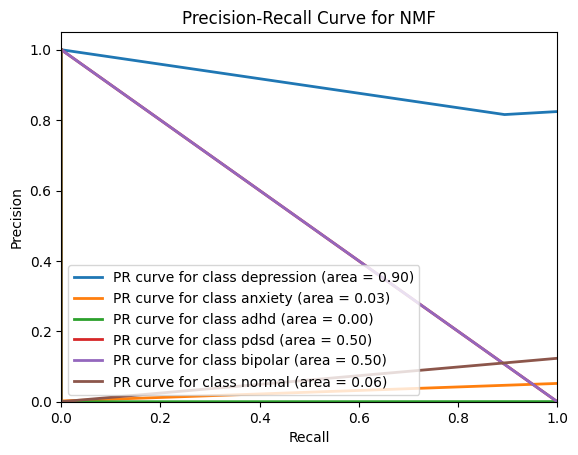

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


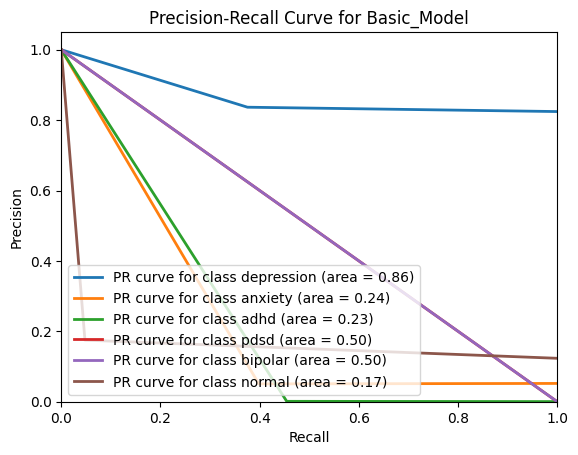

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Bert':
        plot_pr_curve(model_name, dfs['Bert'], model_df, labels)

## Comparative Analysis of Other Models vs. Distilbert Model

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'Distilbert':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['Distilbert'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-

+-------------+----------------+-----------------+--------------+----------------+
| Model       |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+=============+================+=================+==============+================+
| Bert        |       1.11062  |        79.0631  |     1.11062  |       0.841179 |
+-------------+----------------+-----------------+--------------+----------------+
| Xlnet       |      13.5331   |        61.0047  |    13.5331   |      11.1973   |
+-------------+----------------+-----------------+--------------+----------------+
| Zero_Shot   |      11.9194   |        60.2049  |    11.9194   |      19.8532   |
+-------------+----------------+-----------------+--------------+----------------+
| GPT2        |       0.455639 |         1.52771 |     0.455639 |       0.701928 |
+-------------+----------------+-----------------+--------------+----------------+
| LDA         |       2.64207  |        66.6102  |     2.64207  |       4.87987  |
+---

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Distilbert':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['Distilbert'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.


Classification Report for Bert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| anxiety    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| adhd       |        1    |     0    |       0    |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| normal     |        0.09 |     0.16 |       0.11 |
+------------+-------------+----------+------------+

Classification Report for Xlnet:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

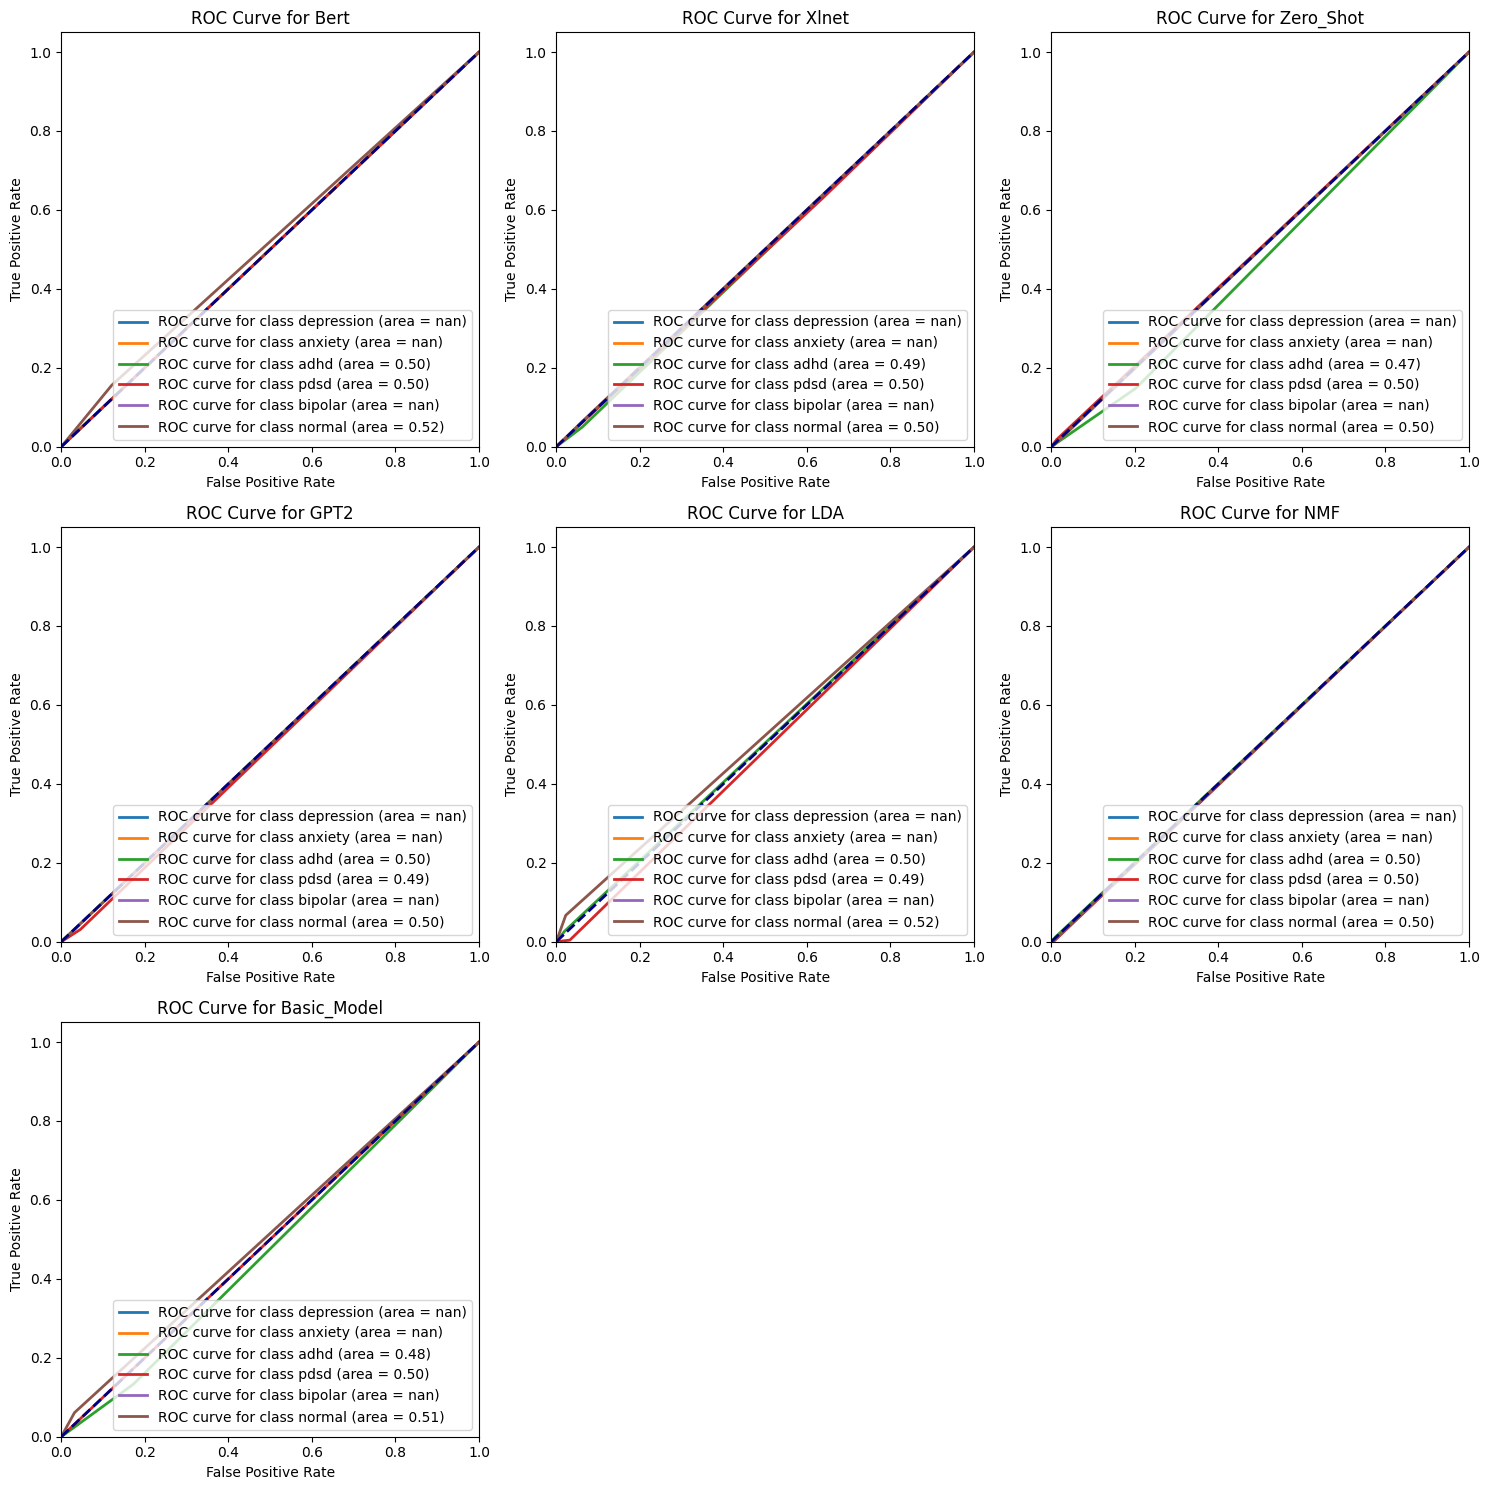

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'Distilbert':
        plot_roc_curve(axes[index], model_name, dfs['Distilbert']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


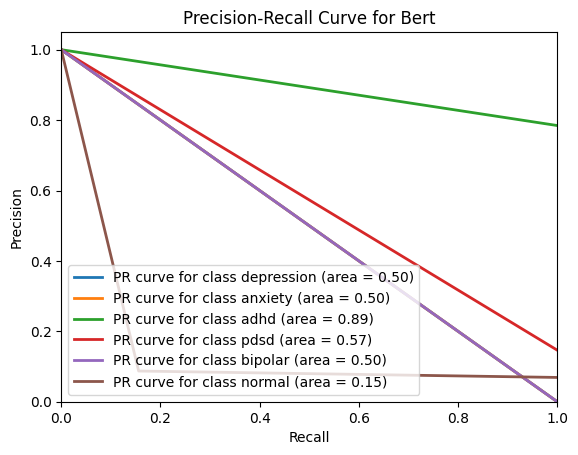

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


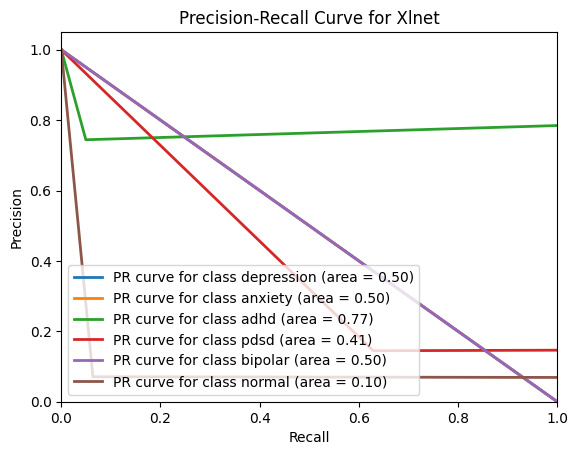

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


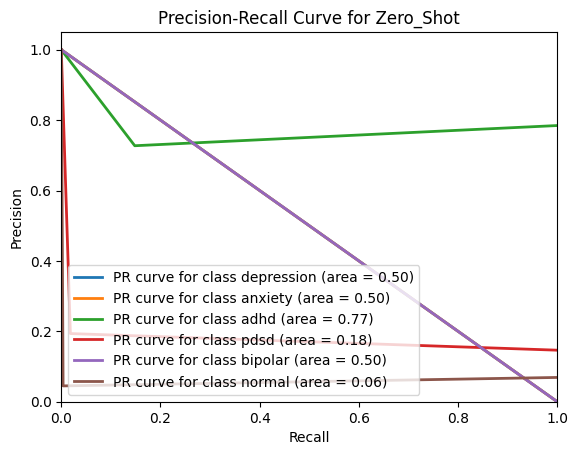

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


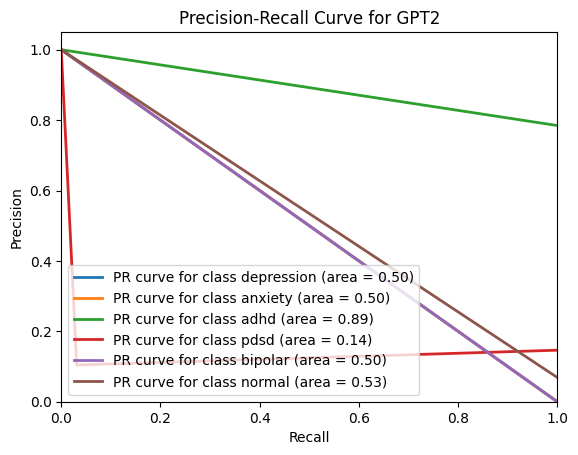

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


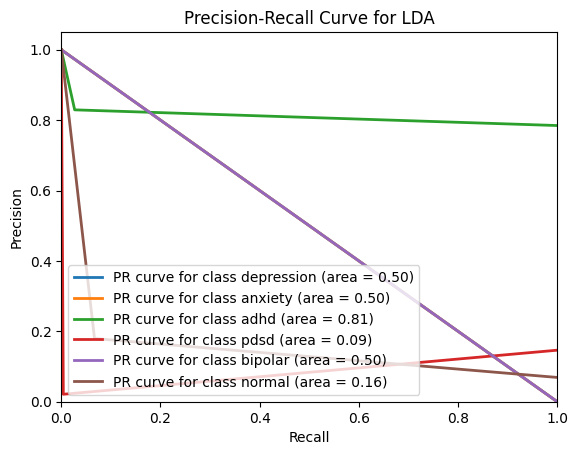

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


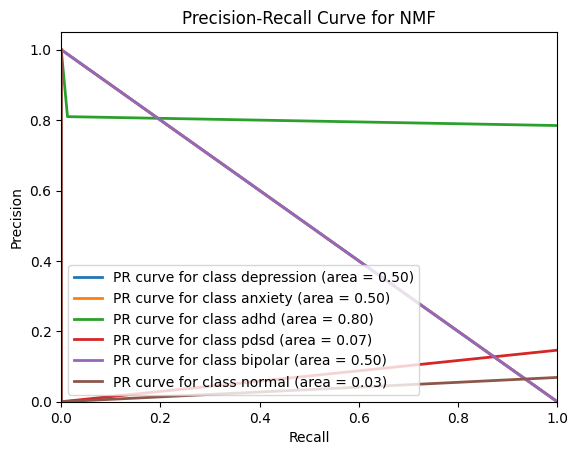

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


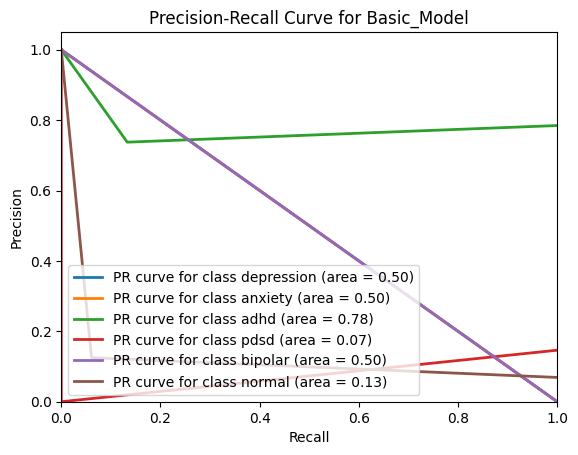

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Distilbert':
        plot_pr_curve(model_name, dfs['Distilbert'], model_df, labels)

## Comparative Analysis of Other Models vs. Xlnet Model

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'Xlnet':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['Xlnet'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+-------------+----------------+-----------------+--------------+----------------+
| Model       |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+=============+================+=================+==============+================+
| Bert        |       2.73067  |         8.4405  |     2.73067  |      3.31333   |
+-------------+----------------+-----------------+--------------+----------------+
| Distilbert  |      13.5331   |        40.6287  |    13.5331   |     15.8689    |
+-------------+----------------+-----------------+--------------+----------------+
| Zero_Shot   |      12.5807   |        47.1506  |    12.5807   |      9.99879   |
+-------------+----------------+-----------------+--------------+----------------+
| GPT2        |      27.4048   |        55.7728  |    27.4048   |     16.19      |
+-------------+----------------+-----------------+--------------+----------------+
| LDA         |       3.58815  |        46.901   |     3.58815  |      5.90908   |
+---

In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Xlnet':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['Xlnet'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for Bert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0    |     0.81 |       0.01 |
+------------+-------------+----------+------------+
| anxiety    |        0.33 |     0.07 |       0.11 |
+------------+-------------+----------+------------+
| adhd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| normal     |        0.06 |     0.12 |       0.08 |
+------------+-------------+----------+------------+

Classification Report for Distilbert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============

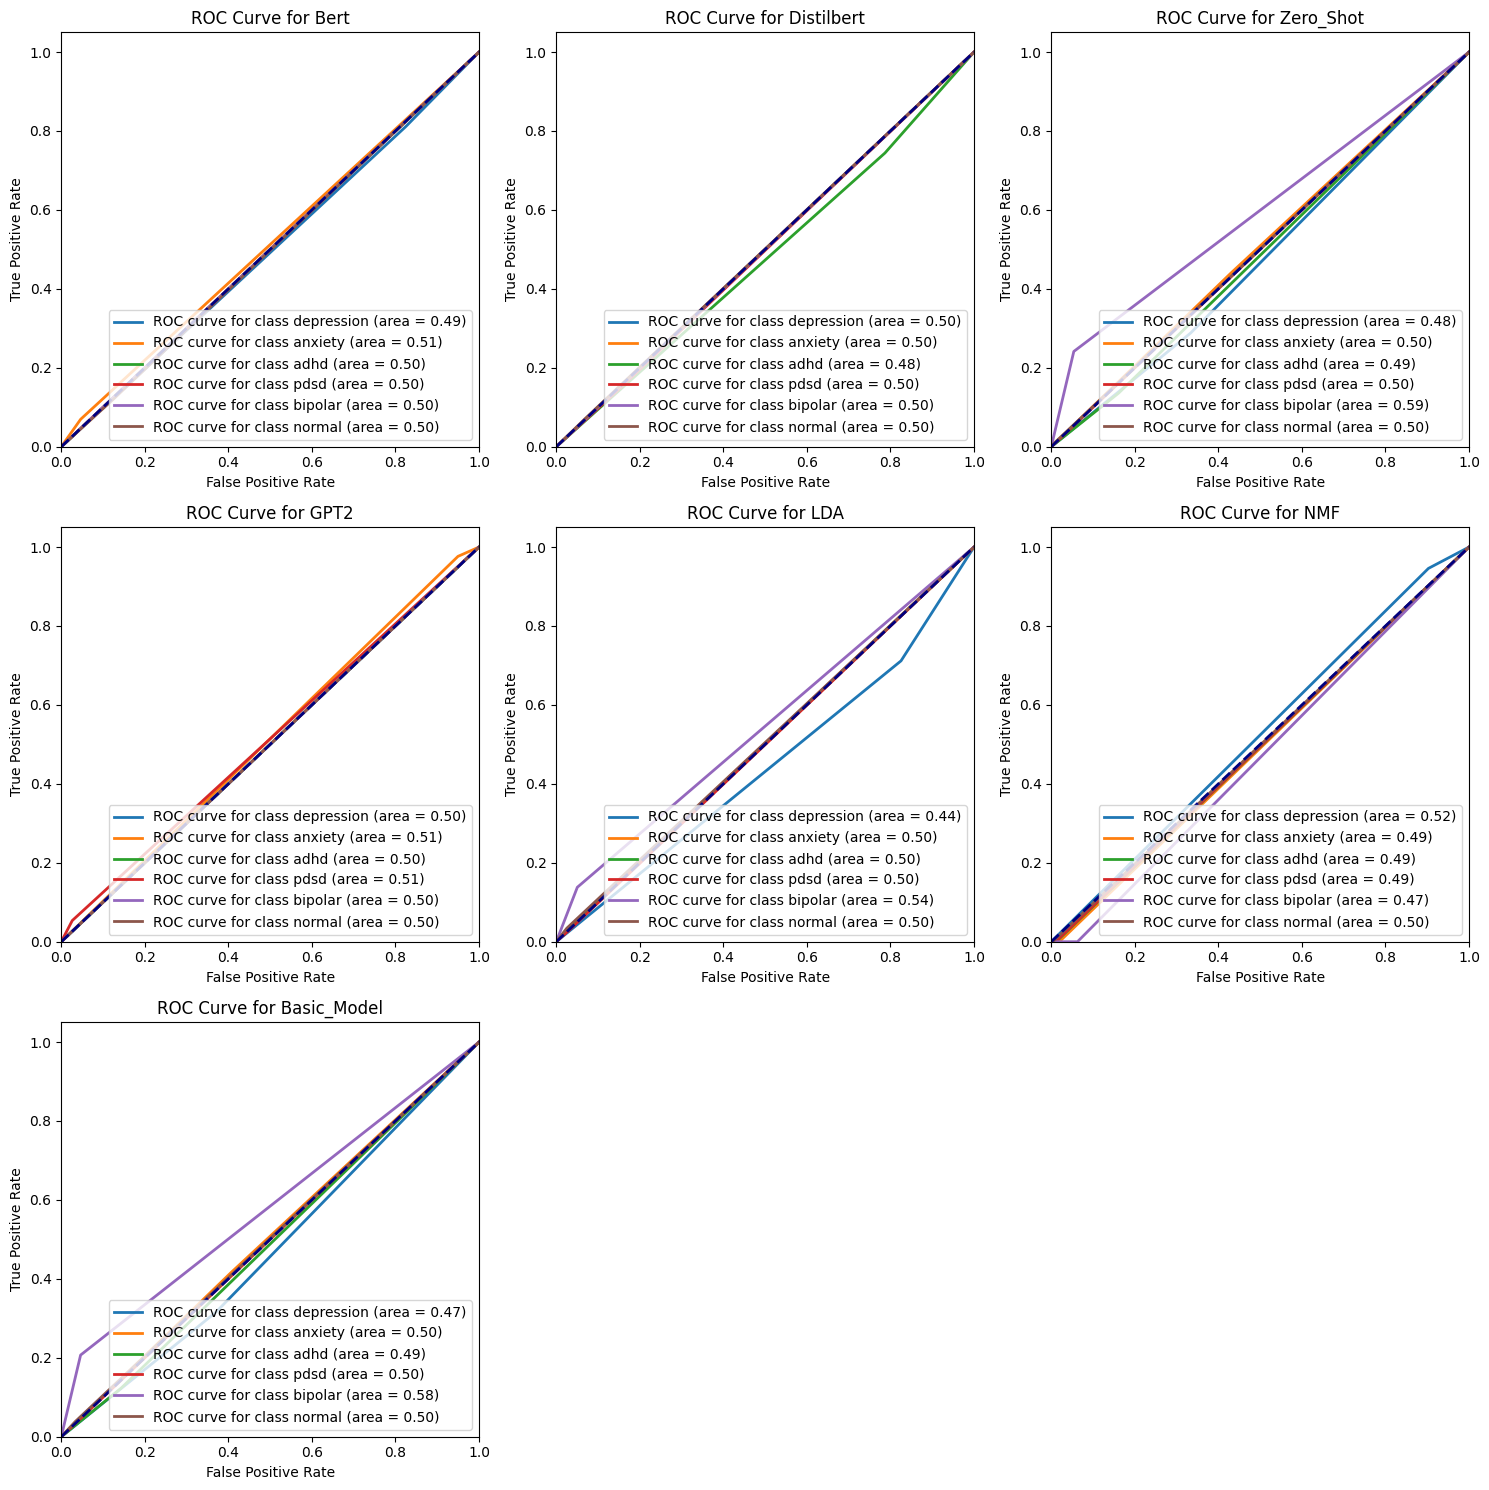

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'Xlnet':
        plot_roc_curve(axes[index], model_name, dfs['Xlnet']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

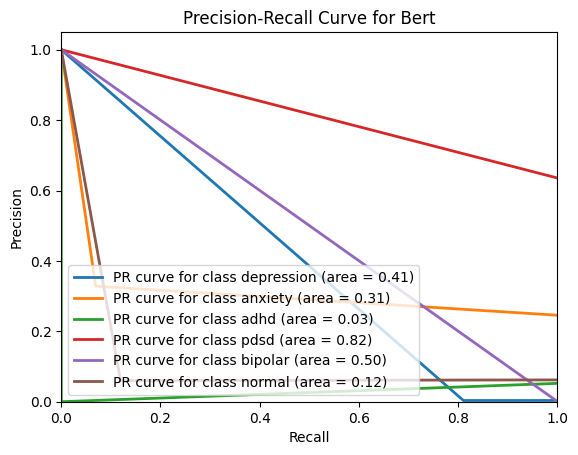

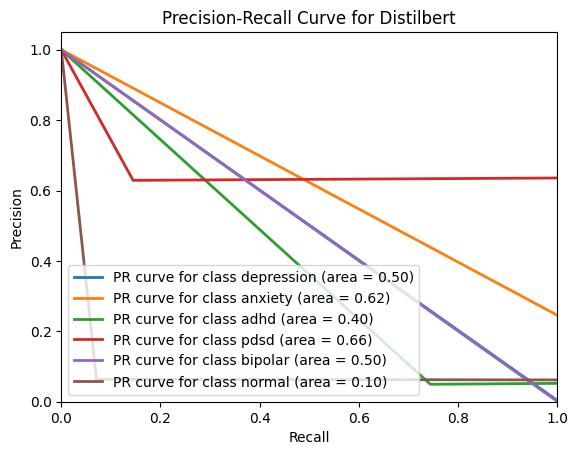

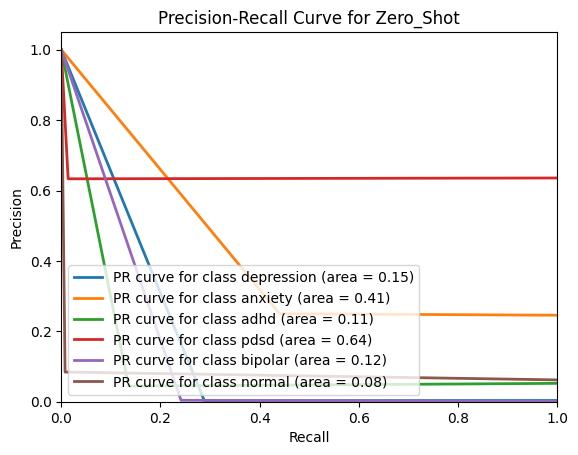

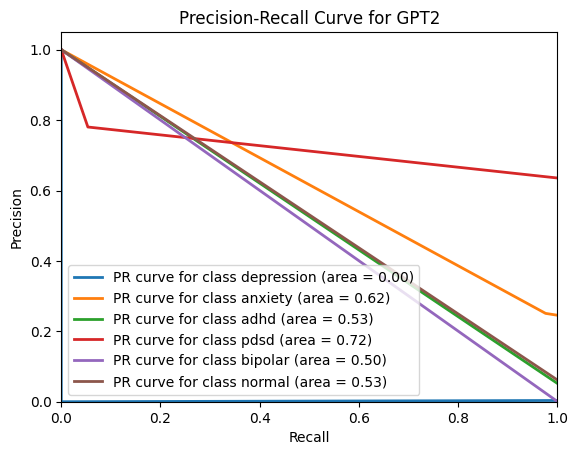

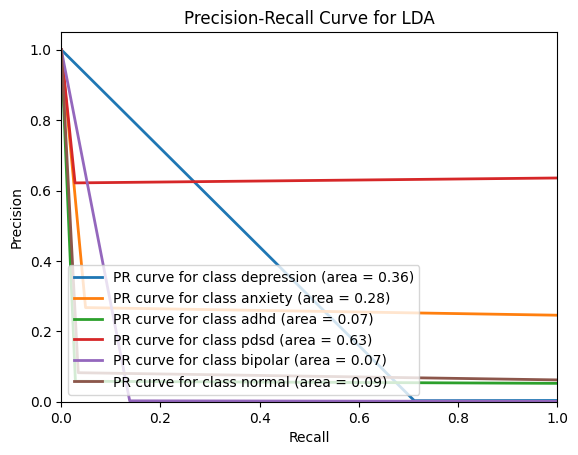

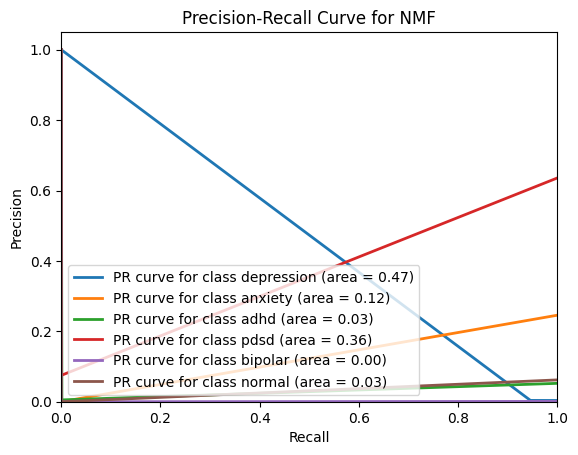

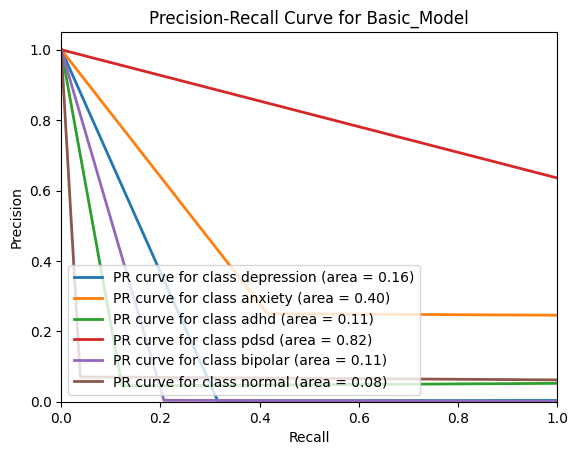

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Xlnet':
        plot_pr_curve(model_name, dfs['Xlnet'], model_df, labels)

## Comparative Analysis of Other Models vs. LDA Model

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'LDA':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['LDA'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+-------------+----------------+-----------------+--------------+----------------+
| Model       |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+=============+================+=================+==============+================+
| Bert        |       68.0642  |       67.885    |     68.0642  |      67.9182   |
+-------------+----------------+-----------------+--------------+----------------+
| Distilbert  |        2.64207 |        0.253005 |      2.64207 |       0.404276 |
+-------------+----------------+-----------------+--------------+----------------+
| Xlnet       |        3.58815 |       59.8665   |      3.58815 |       1.26723  |
+-------------+----------------+-----------------+--------------+----------------+
| Zero_Shot   |       29.9709  |       68.6687   |     29.9709  |      40.1864   |
+-------------+----------------+-----------------+--------------+----------------+
| GPT2        |        4.28427 |       82.7072   |      4.28427 |       0.412326 |
+---

In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'LDA':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['LDA'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for Bert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0.82 |     0.82 |       0.82 |
+------------+-------------+----------+------------+
| anxiety    |        0.09 |     0.1  |       0.1  |
+------------+-------------+----------+------------+
| adhd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| normal     |        0.02 |     0.08 |       0.03 |
+------------+-------------+----------+------------+

Classification Report for Distilbert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============

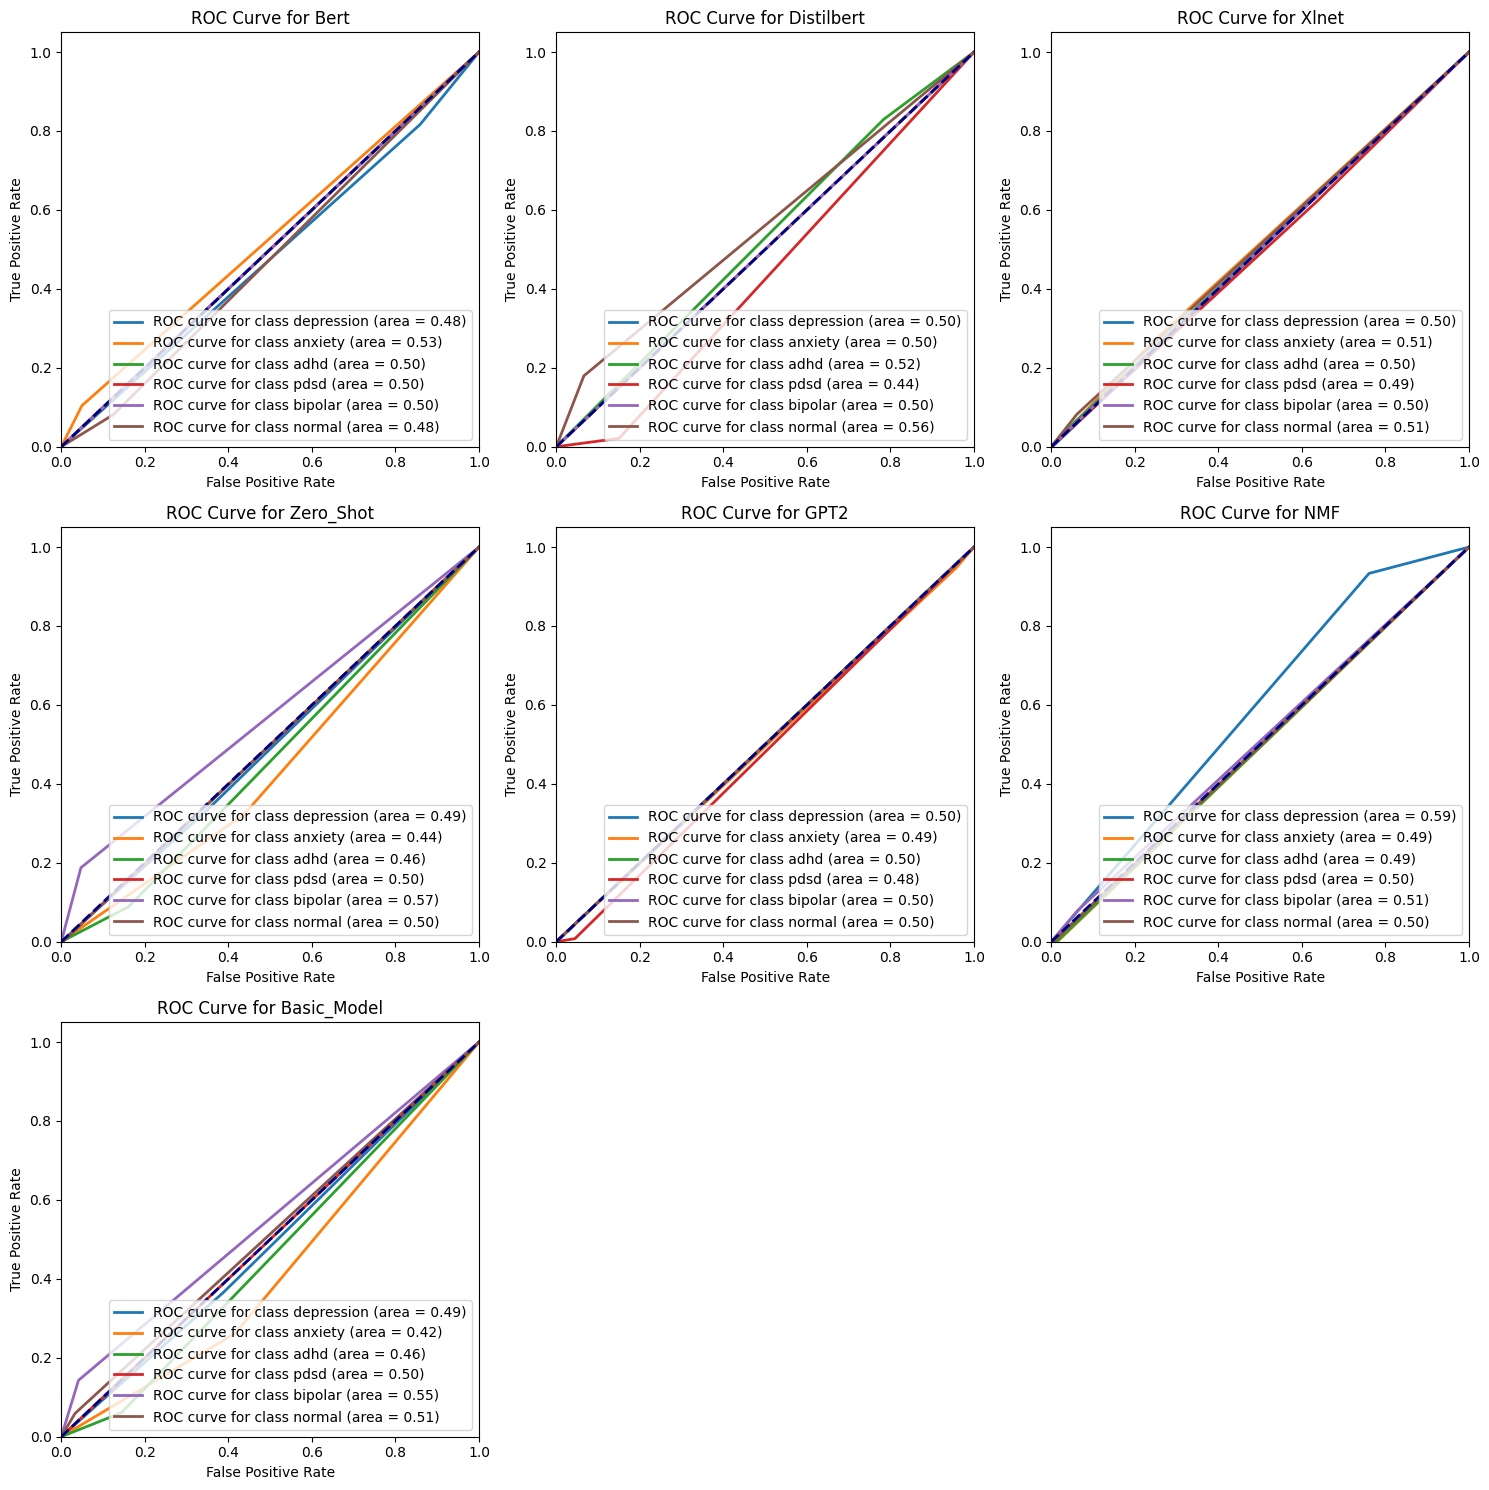

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'LDA':
        plot_roc_curve(axes[index], model_name, dfs['LDA']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

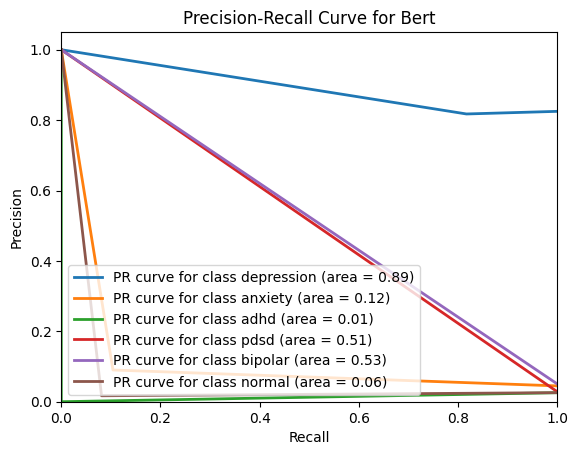

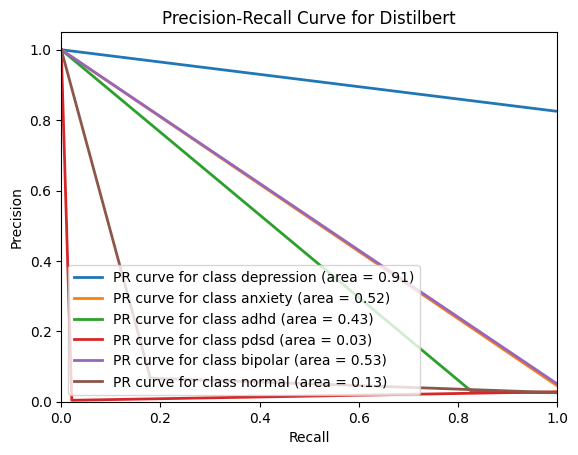

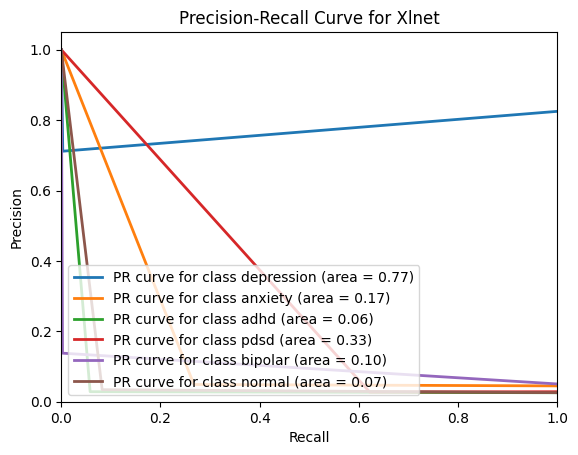

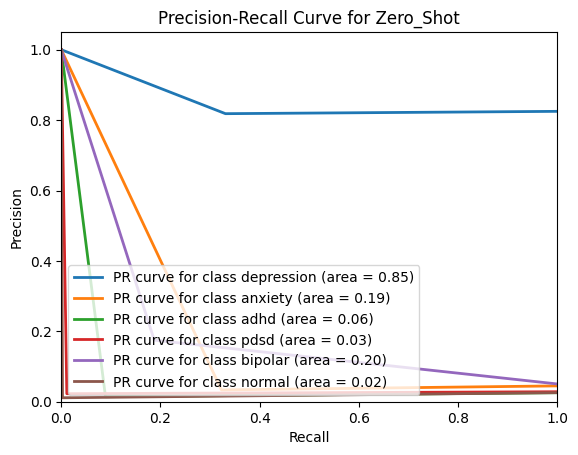

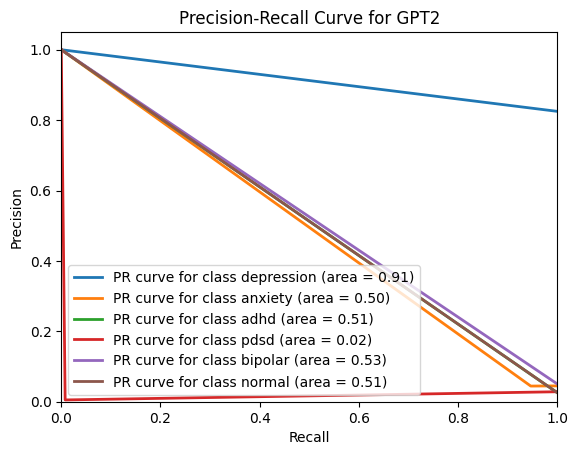

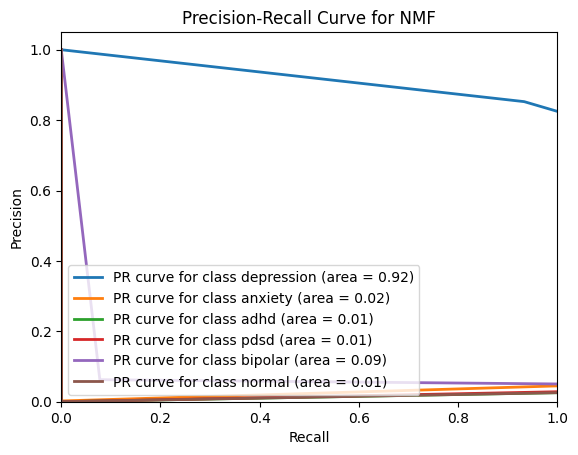

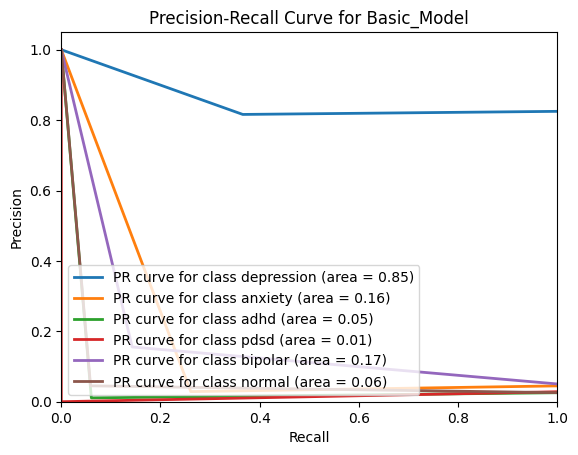

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'LDA':
        plot_pr_curve(model_name, dfs['LDA'], model_df, labels)

## Comparative Analysis of Other Models vs. NMF Model

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'NMF':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['NMF'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+-------------+----------------+-----------------+--------------+----------------+
| Model       |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+=============+================+=================+==============+================+
| Bert        |      73.6742   |      80.7076    |    73.6742   |     77.03      |
+-------------+----------------+-----------------+--------------+----------------+
| Distilbert  |       0.984053 |       0.0152388 |     0.984053 |      0.0300128 |
+-------------+----------------+-----------------+--------------+----------------+
| Xlnet       |       0.370206 |      85.4254    |     0.370206 |      0.664704  |
+-------------+----------------+-----------------+--------------+----------------+
| Zero_Shot   |      30.8189   |      82.3695    |    30.8189   |     44.7484    |
+-------------+----------------+-----------------+--------------+----------------+
| GPT2        |       0.291102 |      90.3093    |     0.291102 |      0.0211764 |
+---

In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'NMF':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['NMF'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for Bert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0.89 |     0.82 |       0.85 |
+------------+-------------+----------+------------+
| anxiety    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| adhd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| normal     |        0    |     0    |       0    |
+------------+-------------+----------+------------+

Classification Report for Distilbert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============

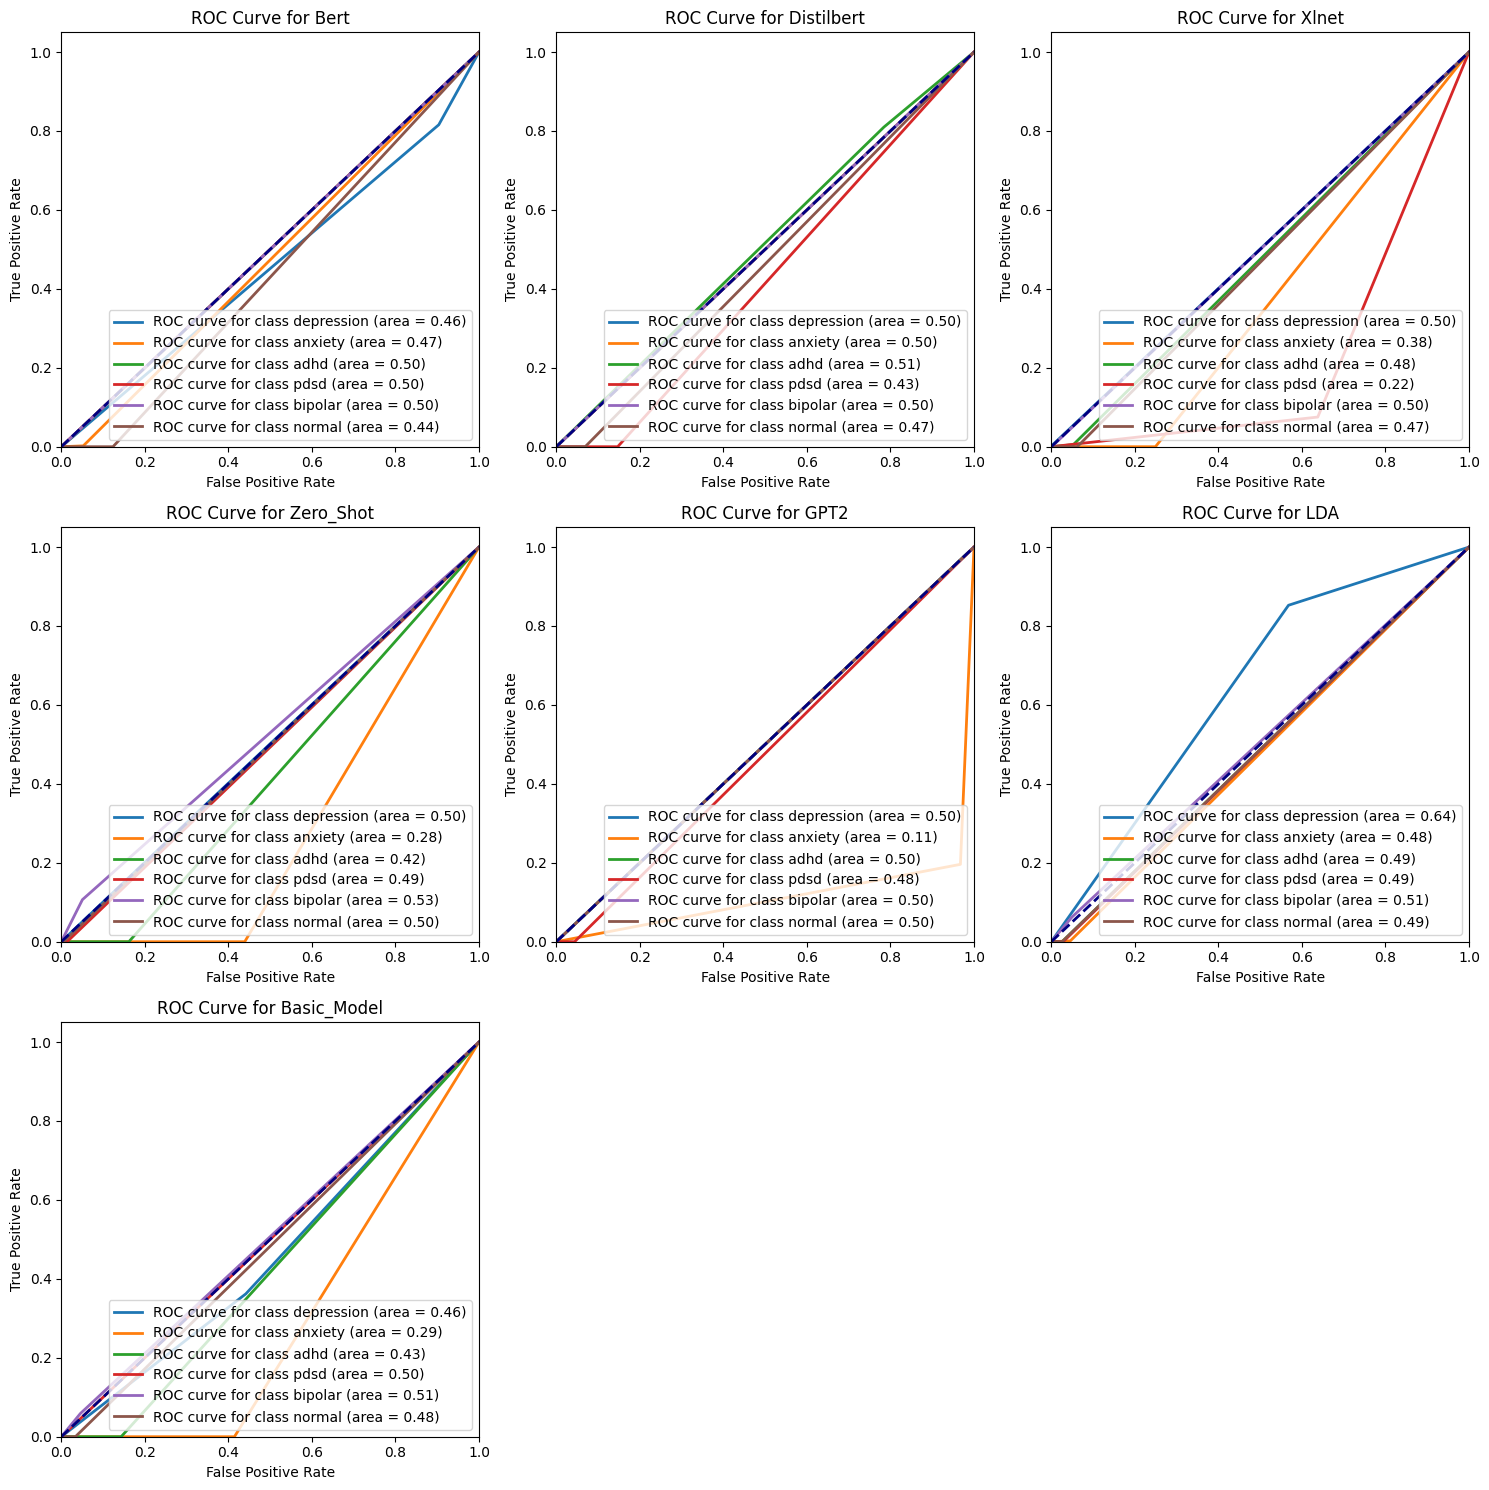

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'NMF':
        plot_roc_curve(axes[index], model_name, dfs['NMF']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

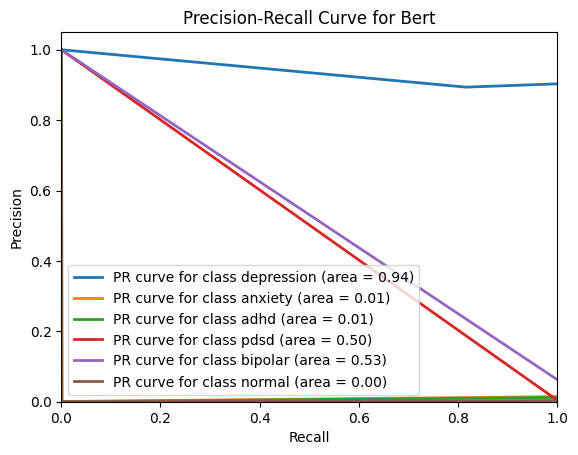

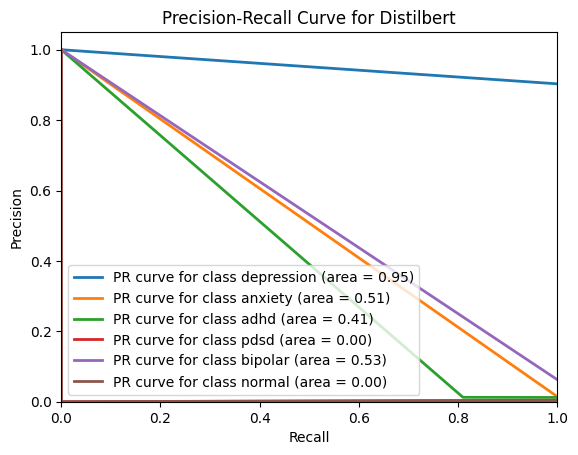

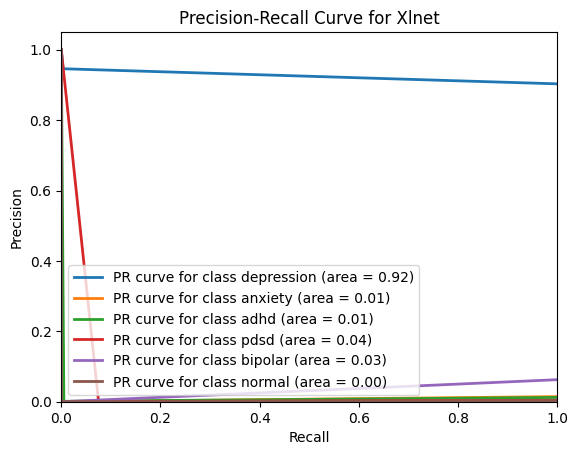

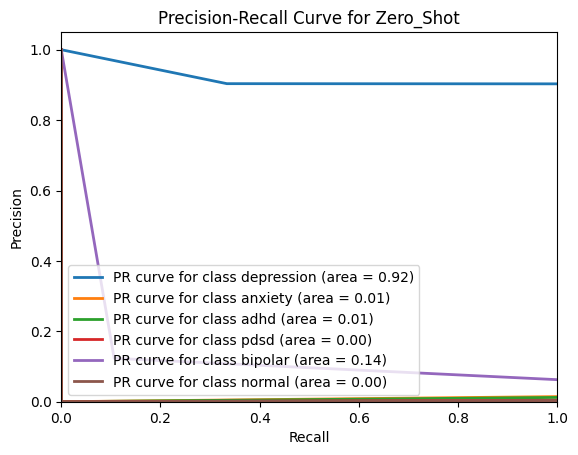

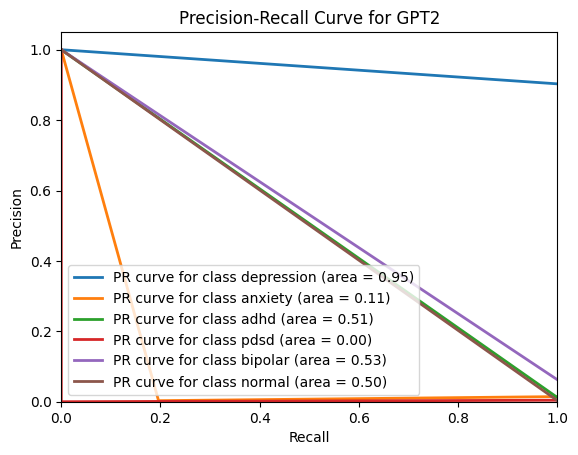

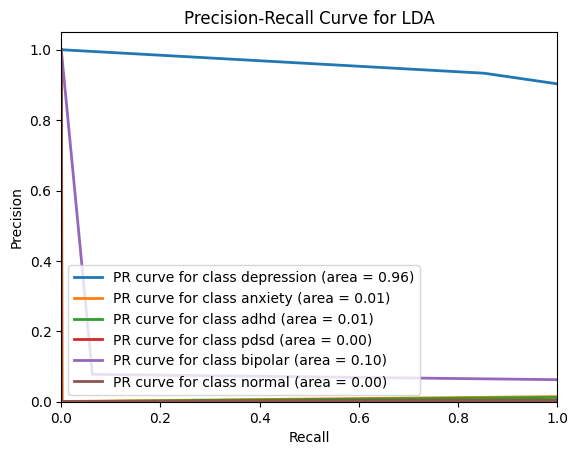

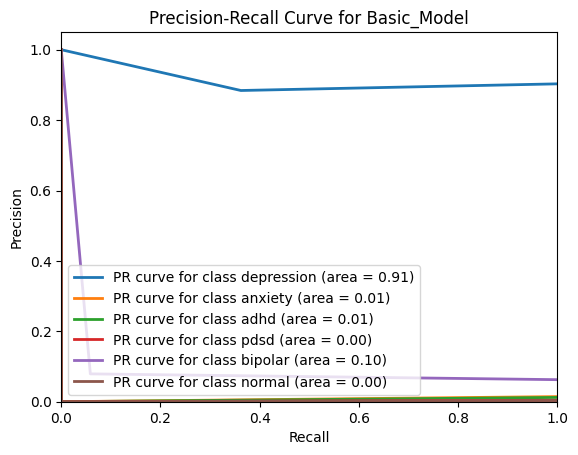

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'NMF':
        plot_pr_curve(model_name, dfs['NMF'], model_df, labels)

## Comparative Analysis of Other Models vs. GPT2

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'GPT2':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['GPT2'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

+-------------+----------------+-----------------+--------------+----------------+
| Model       |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+=============+================+=================+==============+================+
| Bert        |       5.02468  |       92.424    |     5.02468  |       9.5255   |
+-------------+----------------+-----------------+--------------+----------------+
| Distilbert  |       0.455639 |        0.135894 |     0.455639 |       0.209349 |
+-------------+----------------+-----------------+--------------+----------------+
| Xlnet       |      27.4048   |       93.6082   |    27.4048   |      38.6195   |
+-------------+----------------+-----------------+--------------+----------------+
| Zero_Shot   |      41.9789   |       92.8375   |    41.9789   |      57.8079   |
+-------------+----------------+-----------------+--------------+----------------+
| LDA         |       4.28427  |       90.5468   |     4.28427  |       8.15621  |
+---

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'GPT2':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['GPT2'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.


Classification Report for Bert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0    |     0.5  |        0   |
+------------+-------------+----------+------------+
| anxiety    |        0.97 |     0.05 |        0.1 |
+------------+-------------+----------+------------+
| adhd       |        0    |     0    |        0   |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |        0   |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |        0   |
+------------+-------------+----------+------------+
| normal     |        0    |     0    |        0   |
+------------+-------------+----------+------------+

Classification Report for Distilbert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

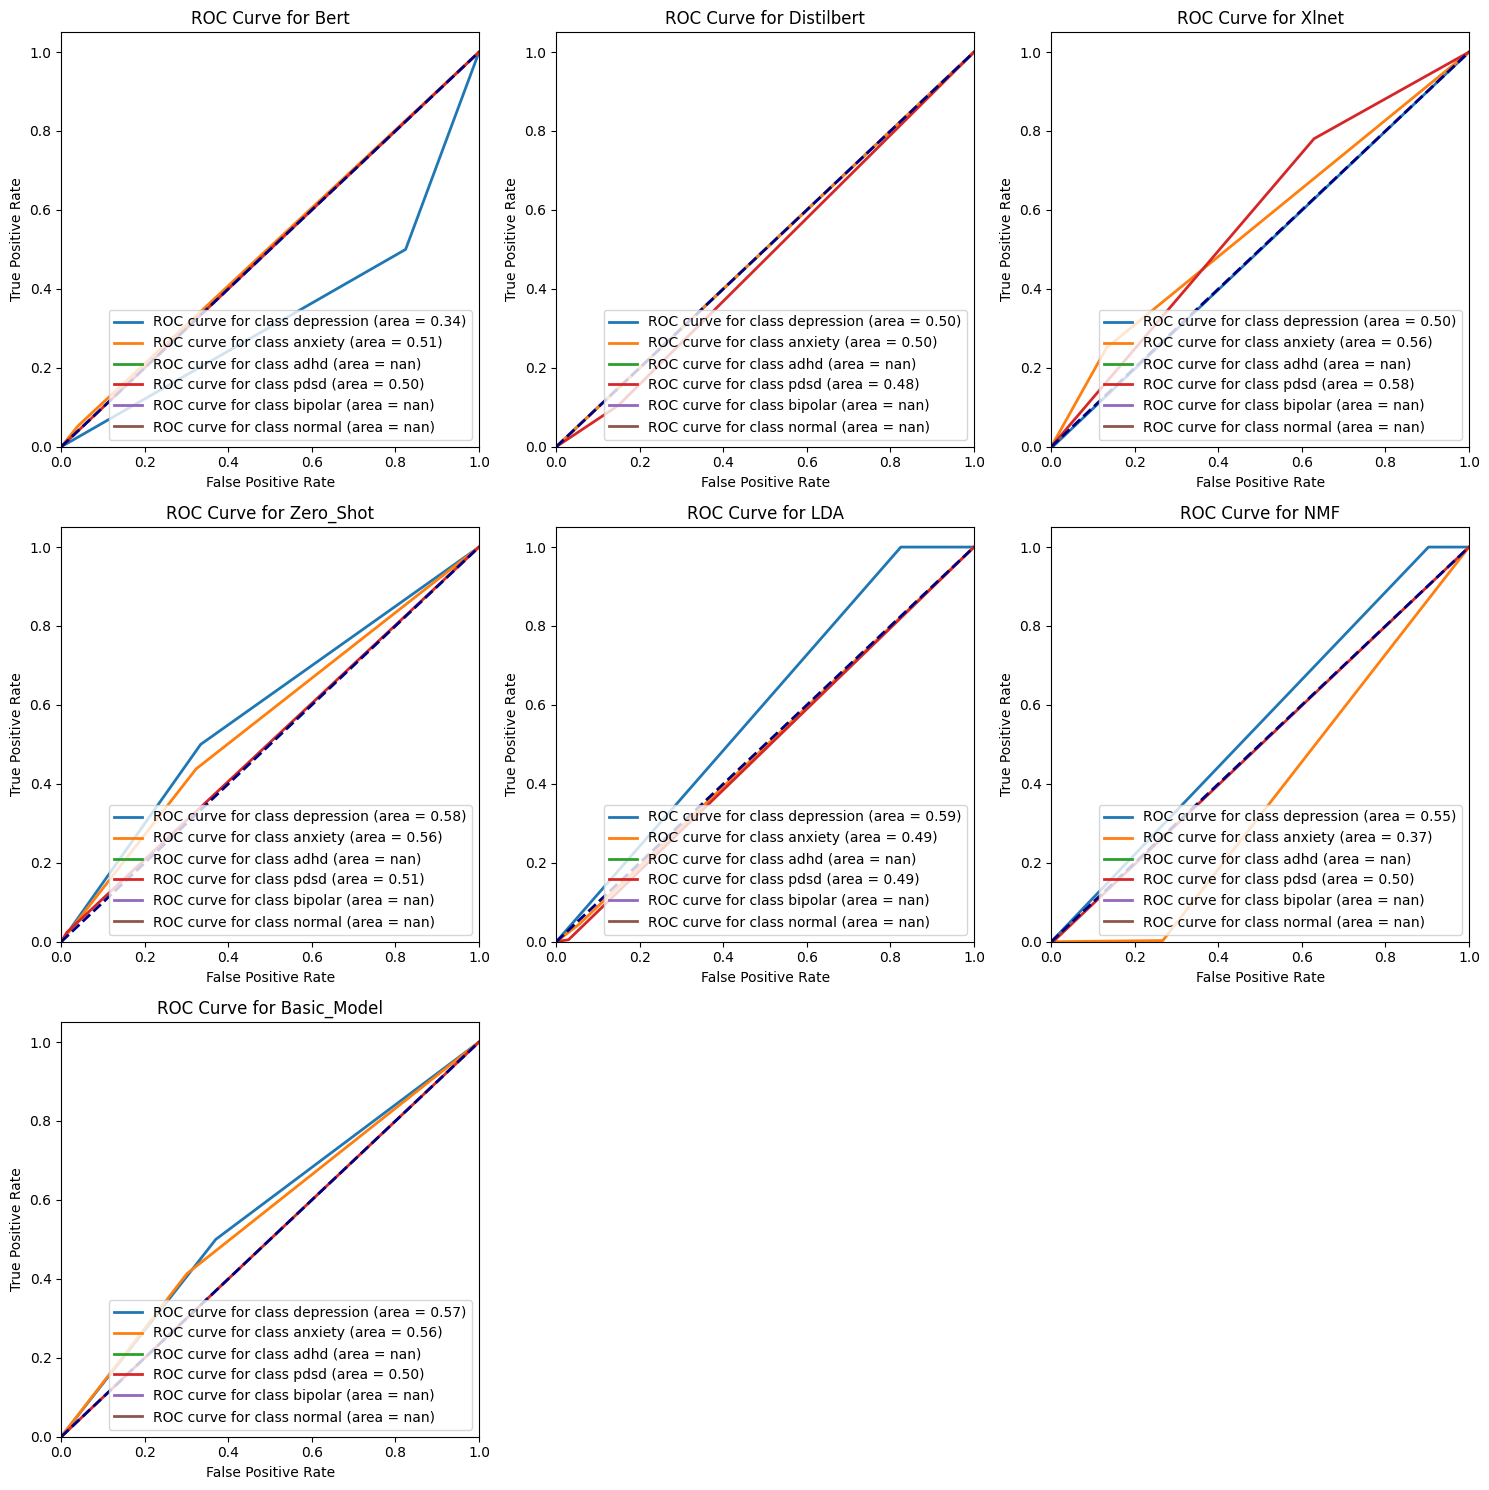

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'GPT2':
        plot_roc_curve(axes[index], model_name, dfs['GPT2']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


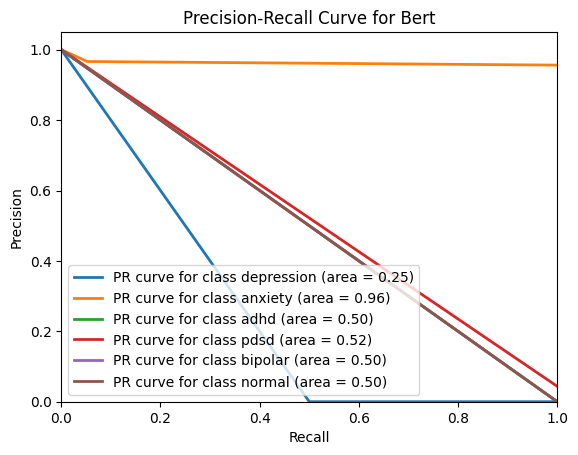

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


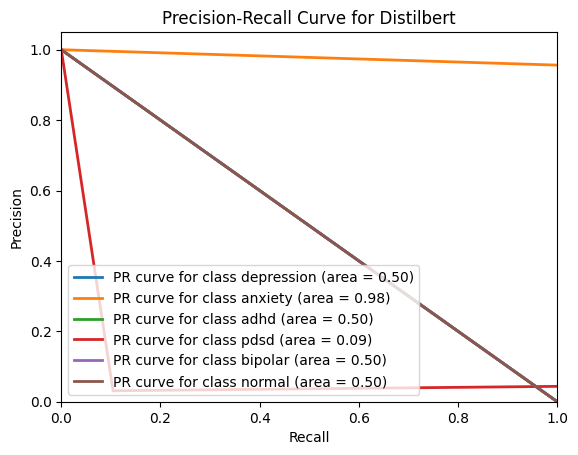

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


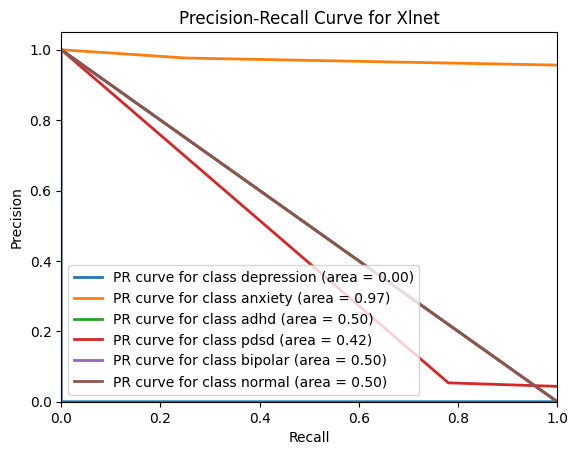

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


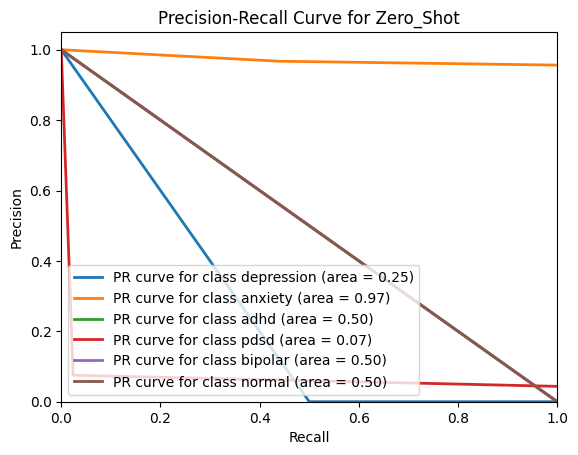

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


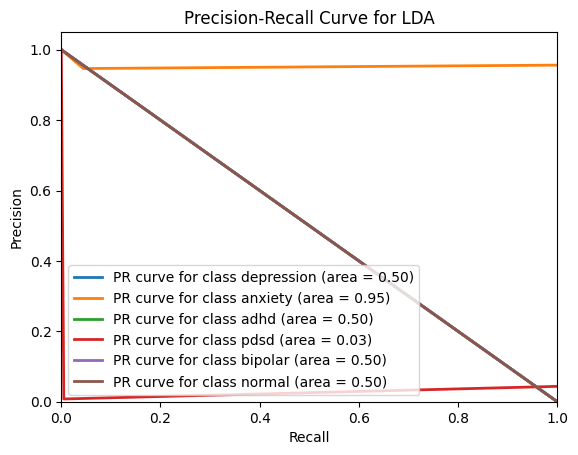

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


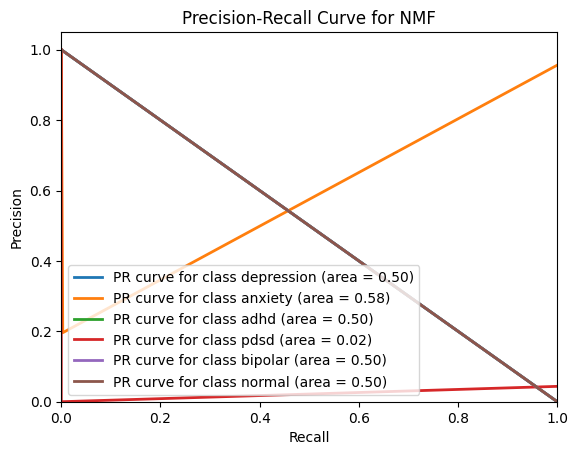

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


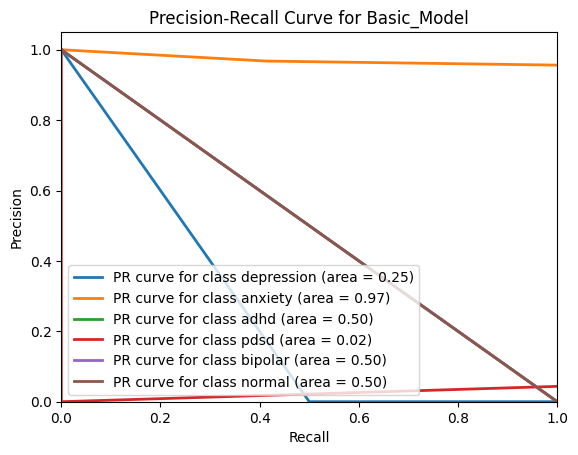

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'GPT2':
        plot_pr_curve(model_name, dfs['GPT2'], model_df, labels)

## Comparative Analysis of Other Models vs. Zero Shot Classification

In [ ]:
def compare_llm_models(model_name, basic_model, other_model):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    accuracy = accuracy_score(basic_labels, other_labels) * 100
    f1 = f1_score(basic_labels, other_labels, average='weighted') * 100
    precision = precision_score(basic_labels, other_labels, average='weighted') * 100
    recall = recall_score(basic_labels, other_labels, average='weighted') * 100
    return accuracy,precision, recall,f1

table_data = []
for model_name, model_df in dfs.items():
    if model_name != 'Zero_Shot':
        accuracy, f1, precision, recall = compare_llm_models(model_name, dfs['Zero_Shot'], model_df)
        table_data.append([model_name, accuracy, f1, precision, recall])
headers = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
print(tabulate(table_data, headers=headers, tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+-------------+----------------+-----------------+--------------+----------------+
| Model       |   Accuracy (%) |   Precision (%) |   Recall (%) |   F1 Score (%) |
+=============+================+=================+==============+================+
| Bert        |        29.9741 |        38.0653  |      29.9741 |       19.8877  |
+-------------+----------------+-----------------+--------------+----------------+
| Distilbert  |        11.9194 |         2.39602 |      11.9194 |        3.98558 |
+-------------+----------------+-----------------+--------------+----------------+
| Xlnet       |        12.5807 |        32.178   |      12.5807 |       15.1626  |
+-------------+----------------+-----------------+--------------+----------------+
| GPT2        |        41.9789 |        35.6695  |      41.9789 |       26.1499  |
+-------------+----------------+-----------------+--------------+----------------+
| LDA         |        29.9709 |        27.4822  |      29.9709 |       19.7553  |
+---

In [ ]:
def generate_classification_report(model_name, basic_model, other_model, target_names):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    return classification_report(basic_labels, other_labels, target_names=target_names, labels=target_names)

table_data = []
classification_reports = {}
labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Zero_Shot':
        classification_reports[model_name] = generate_classification_report(model_name, dfs['Zero_Shot'], model_df, labels)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    model_table_data = [['Label', 'Precision', 'Recall', 'F1-Score']]
    for label in labels:
        label_line = [line for line in report.split('\n') if label in line]
        if label_line:
            precision, recall, f1_score, _ = map(float, label_line[0].strip().split()[1:])
            model_table_data.append([label, precision, recall, f1_score])
        else:
            model_table_data.append([label, 'NaN', 'NaN', 'NaN'])
    print(tabulate(model_table_data, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for Bert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============+==========+============+
| depression |        0.34 |     0.83 |       0.48 |
+------------+-------------+----------+------------+
| anxiety    |        0.42 |     0.05 |       0.09 |
+------------+-------------+----------+------------+
| adhd       |        0.55 |     0    |       0    |
+------------+-------------+----------+------------+
| pdsd       |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| bipolar    |        0    |     0    |       0    |
+------------+-------------+----------+------------+
| normal     |        0.01 |     0.17 |       0.01 |
+------------+-------------+----------+------------+

Classification Report for Distilbert:
+------------+-------------+----------+------------+
| Label      |   Precision |   Recall |   F1-Score |
+============+=============

In [ ]:
def plot_roc_curve(ax, model_name, basic_labels, other_labels):
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    lw = 2
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        ax.plot(fpr, tpr, lw=lw, label=f'ROC curve for class {labels[i]} (area = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc="lower right")

num_models = len(dfs) - 1
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten() if num_rows > 1 else [axes]

index = 0
for model_name, model_df in dfs.items():
    if model_name != 'Zero_Shot':
        plot_roc_curve(axes[index], model_name, dfs['Zero_Shot']['label'], model_df['label'])
        index += 1

for i in range(index, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
def plot_pr_curve(model_name, basic_model, other_model, labels):
    basic_labels = basic_model['label']
    other_labels = other_model['label']
    basic_labels_bin = label_binarize(basic_labels, classes=labels)
    other_labels_bin = label_binarize(other_labels, classes=labels)
    n_classes = len(labels)
    plt.figure()
    lw = 2
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(basic_labels_bin[:, i], other_labels_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=lw, label='PR curve for class %s (area = %0.2f)' % (labels[i], pr_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")
    plt.show()


labels = ['depression', 'anxiety', 'adhd', 'pdsd', 'bipolar','normal']

for model_name, model_df in dfs.items():
    if model_name != 'Zero_Shot':
        plot_pr_curve(model_name, dfs['Zero_Shot'], model_df, labels)